# Predicting the Outcome of Chess Games

This is a dataset with over 20,000 chess games played on [Lichess.org](https://lichess.org/). It was downloaded from Kaggle, [here](https://www.kaggle.com/datasnaek/chess), for use in this project. This data was gathered using the Lichess [API](https://lichess.org/api).

The following columns are available in this dataset:

- **`id`**: the ID of the game;
- **`rated`**: whether the game was rated (affected players' ratings) or not:
 - `True`
 - `False`
- **`create_at`**: start timestamp;
- **`last_move_at`**: end timestamp;
- **`turns`**: number of turns during the game (equals to the numbers of moves);
- **`victory_status`**: victory condition:
 - `draw`
 - `mate`
 - `outoftime`
 - `resign`
- **`winner`**: winning side:
 - `black`
 - `draw`
 - `white`
- **`increment_code`**: the game's timing in the format $a+b$;
- **`white_id`**: ID of the _white_ player;
- **`white_rating`**: _white_ player's _skill rating_;
- **`black_id`**: ID of the _black_ player;
- **`black_rating`**: _black_ player's _skill rating_;
- **`moves`**: list of all the moves during the game in standard chess notation, also known as [Algebraic Notation](https://en.wikipedia.org/wiki/Algebraic_notation_(chess));
 - the columns of the board, also called _files_, are labeled `A` through `H`;
 - the rows of the board, also called _ranks_, are labeled `1` through `8`;
![Chess board](https://4.bp.blogspot.com/-q1V7fUj_dPg/UCSi5RJWkrI/AAAAAAAAAFw/9maalysCBnE/s1600/ChessBoard2.jpg)
- **`opening_eco`**: the [code](https://www.365chess.com/eco.php) of the _opening_ move of the game;
- **`opening_name`**: the name of the _opening_ move of the game;
- **`opening_ply`**: the number of moves in the _opening_ sequence.

## The Goal

In this project, our goal is to develop a classification model to predict the outcome of chess games from Lichess, based on supervised machine learning over this dataset. We're aiming for a classification model with a precision of at least 80%.

## The Dataset

I'll begin by loading the dataset. I'll call it `df_chess`.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

df_chess = pd.read_csv('games.csv')

df_chess.head(5)

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5


### Assessing the Dataset's Integrity

We'll look for possible integrity problems in the dataset, such as _null_ or invalid values and outliers. We'll also correct any errors that we find along the way and even make replace values or add new columns.

Are there any _null_ values in the dataset?

In [2]:
(df_chess.count() < len(df_chess.index)).any()

False

There are no _null_ values. Let's check the columns for their types and non-null values count.

In [3]:
df_chess.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              20058 non-null  object 
 1   rated           20058 non-null  bool   
 2   created_at      20058 non-null  float64
 3   last_move_at    20058 non-null  float64
 4   turns           20058 non-null  int64  
 5   victory_status  20058 non-null  object 
 6   winner          20058 non-null  object 
 7   increment_code  20058 non-null  object 
 8   white_id        20058 non-null  object 
 9   white_rating    20058 non-null  int64  
 10  black_id        20058 non-null  object 
 11  black_rating    20058 non-null  int64  
 12  moves           20058 non-null  object 
 13  opening_eco     20058 non-null  object 
 14  opening_name    20058 non-null  object 
 15  opening_ply     20058 non-null  int64  
dtypes: bool(1), float64(2), int64(4), object(9)
memory usage: 2.3+ MB


#### `id`

Given that the `id` doesn't seem to be numerical, we should check for invalid values, such as empty or blank (spaces) values.

We'll do so by trimming blank characters from the IDs and checking if all resulting values are `True` (i.e. non-empty strings).

In [4]:
df_chess['id'].str.strip().apply(bool).all()

True

There's no empty or blank values for `id`.

One would assume that each game ID is unique. Is that the case?

In [5]:
not df_chess['id'].duplicated().any()

False

So there are duplicated IDs. But are those games the same? That is, are there entirely duplicated rows?

In [6]:
df_chess.duplicated().any()

True

I'll remove those duplicated rows from the dataset.

In [7]:
df_chess.drop_duplicates(inplace=True)

Any duplicates remaining?

In [8]:
df_chess.duplicated().any()

False

No. Good.

#### `created_at` and `last_move_at`

Both the start and end timestamps are in microseconds since `1970-01-01 00:00:00.000000`, which is the standard for JavaScript date and time, as far as I understand it. That's possibly because the data was retireved via the Lichess.org API (according to the source), in which the data is requested as JSON.

In [9]:
df_chess[['created_at', 'last_move_at']].describe()

,created_at,last_move_at
count,1.962900e+04,1.962900e+04
mean,1.483721e+12,1.483722e+12
std,2.809364e+10,2.809353e+10
min,1.376772e+12,1.376772e+12
25%,1.477530e+12,1.477530e+12
50%,1.495830e+12,1.495830e+12
75%,1.503107e+12,1.503110e+12
max,1.504493e+12,1.504494e+12


It's easier to handle them as Python `datetime`.

In [10]:
import datetime

timestamp_columns_names = ['created_at', 'last_move_at']

df_chess[timestamp_columns_names] = (
  df_chess[timestamp_columns_names] / 1e3 # 1,000 microseconds
).applymap(datetime.datetime.fromtimestamp)

In [11]:
df_chess[timestamp_columns_names].head()

,created_at,last_move_at
0,2017-08-31 20:06:40,2017-08-31 20:06:40
1,2017-08-30 21:53:20,2017-08-30 21:53:20
2,2017-08-30 21:53:20,2017-08-30 21:53:20
3,2017-08-30 16:20:00,2017-08-30 16:20:00
4,2017-08-29 18:06:40,2017-08-29 18:06:40


A game cannot end before starting. Does `created_at` precedes or equals `last_move_at` for all games?

In [12]:
(df_chess['created_at'] <= df_chess['last_move_at']).all()

True

We can extract the real duration of the games, in milliseconds, from those columns.

In [13]:
df_chess['game_duration'] = (
  df_chess['last_move_at'] - df_chess['created_at']
) / datetime.timedelta(milliseconds=1)

In [14]:
df_chess[['game_duration']].describe()

,game_duration
count,1.962900e+04
mean,8.696767e+05
std,4.863228e+06
min,0.000000e+00
25%,0.000000e+00
50%,2.241710e+05
75%,7.879750e+05
max,6.058447e+08


At least 25% of the games lasted for `0 ms`, and the maximum game duration is about `606,000,000 ms` (almost a week). That does not bode well.

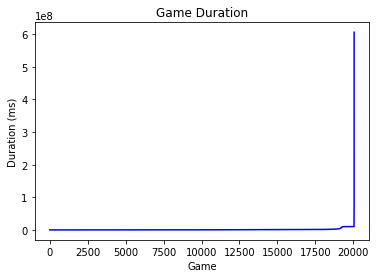

In [15]:
plt.plot(
  df_chess.index,
  sorted(df_chess['game_duration']),
  'b'
)
plt.title('Game Duration')
plt.xlabel('Game')
plt.ylabel('Duration (ms)')
plt.show()

Two points there:

1. Games lasting `0` s shouldn't be a thing;
2. We're definitely checking for outliers.

Let's take a look at those _"`0 s` games"_. Either those players are inhumanly fast, or something is quite out of place. I'm assuming those are games were a player resigned the match before it even started. So I'll look their `turns`, `winner` and `victory_status` values.

In [16]:
filt_instant_games = (df_chess['game_duration'] == 0)

In [17]:
df_chess[['turns']][filt_instant_games].describe()

,turns
count,8533.000000
mean,58.553498
std,32.454929
min,1.000000
25%,35.000000
50%,53.000000
75%,76.000000
max,221.000000


In [18]:
sorted(df_chess['winner'][filt_instant_games].unique())

['black', 'draw', 'white']

In [19]:
sorted(df_chess['victory_status'][filt_instant_games].unique())

['draw', 'mate', 'outoftime', 'resign']

Those are quite diverse results for such impossible games. They aren't all games were someone just gave up, but rather valid games as it seems. The problem must be something else, so I'll leave those three columns -- `created_at`, `last_move_at` and `game_duration` -- and focus on the others.

#### `turns`

This is the number of turns (both players' moves) taken during the game.

In [20]:
df_chess[['turns']].describe()

,turns
count,19629.000000
mean,60.458607
std,33.502852
min,1.000000
25%,37.000000
50%,55.000000
75%,79.000000
max,349.000000


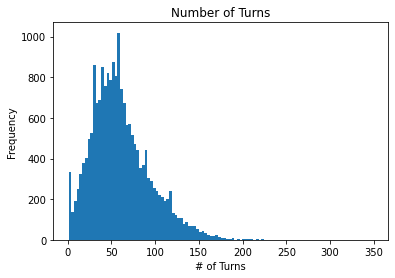

In [21]:
plt.hist(df_chess['turns'], bins='fd')
plt.title('Number of Turns')
plt.ylabel('Frequency')
plt.xlabel('# of Turns')
plt.show()

It seems there's no game with `0` turns, so every game had at least a starting move. This could mean that games with a very small number of moves were won by resignation from one of the players. Aside from that, `turns` seems fine.

It might be worthy taking a look at games with $\le{2}$ moves. Games with `1` or `2` moves are games were basically nothing meaningful really happended because each player made only their initial move.

Is there any game like that in the dataset?

In [22]:
filt_games_too_small = (df_chess['turns'] <= 2)

df_chess[filt_games_too_small].head()

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply,game_duration
141,X4QqWp8Q,True,2017-08-19 08:06:40,2017-08-19 08:06:40,2,resign,black,15+15,pune123,1443,sassou,1204,e4 Nf6,B02,Alekhine Defense,2,0.0
439,37DIkyQP,True,2017-08-04 04:13:20,2017-08-04 04:13:20,2,draw,draw,10+0,marianocharly,1641,kyanh,1502,e4 d5,B01,Scandinavian Defense,2,0.0
460,QYc8zif6,True,2017-08-18 18:13:20,2017-08-18 18:13:20,2,outoftime,black,5+5,fischerdipper,1646,hooponopono,1795,d4 d5,D00,Queen's Pawn Game,2,0.0
1814,2CKxscOK,False,2017-04-28 00:40:00,2017-04-28 03:26:40,2,outoftime,black,15+0,lkasperbauer,1038,andersongot,1331,e4 d5,B01,Scandinavian Defense,2,10000000.0
1946,3K5kYPO8,True,2017-04-07 01:53:20,2017-04-07 01:53:20,1,resign,black,10+0,serik-astana,1464,brorael357,1355,g3,A00,Hungarian Opening,1,0.0


Let's remove them from the dataset, because they'll add no value to the analysis.

In [23]:
df_chess = df_chess[~filt_games_too_small]

Do we have any significant outliers?

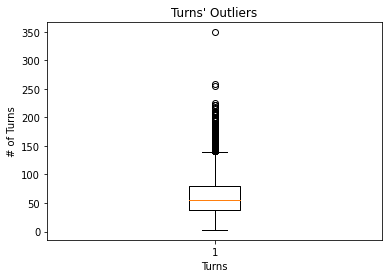

In [24]:
plt.boxplot(df_chess['turns'])
plt.title("Turns' Outliers")
plt.xlabel('Turns')
plt.ylabel('# of Turns')
plt.show()

Possibly, yes.

#### `victory_status`

The `victory_status` column should have only these values:
- `draw`
- `mate`
- `outoftime`
- `resign`

In [25]:
sorted(df_chess['victory_status'].unique())

['draw', 'mate', 'outoftime', 'resign']

Any empty or blank values?

In [26]:
not df_chess['victory_status'].str.strip().apply(bool).all()

False

Nothing to do here.

#### `winner`

There are only three possible results:
- **`black`**: the _black_ player winned;
- **`white`**: the _white_ player winned;
- **`draw`**: the game tied.

In [27]:
sorted(df_chess['winner'].unique())

['black', 'draw', 'white']

Any empty or blank values?

In [28]:
not df_chess['winner'].str.strip().apply(bool).all()

False

No out-of-place values there.

But the relationship between `winner` and `victory_status` begs two questions:
1. does every tied game (`winner` $=$ `draw`) has a `victory_status` $\in\{$ `draw`, `outoftime` $\}$?
1. does every non-tied game (`winner` $\in\{$ `black`, `white` $\}$) has a `victory_status` $\in\{$ `mate`, `outoftime`, `resign` $\}$?

In [29]:
# Question 1:
filt_games_tied = df_chess['winner'].isin(['draw'])

df_chess['victory_status'][filt_games_tied].isin(['draw', 'outoftime']).all()

True

In [30]:
# Question 2:
filt_games_won = df_chess['winner'].isin(['black', 'white'])

df_chess['victory_status'][filt_games_won].isin(['mate', 'outoftime', 'resign']).all()

True

The answer to both questions is `True`, so everything is okay.

#### `increment_code`

According to [Lichess.org](https://lichess.org/faq#time-controls), the games' timing is denoted in the format $a+b$, where $a=$ initial timer in minutes, and $b=$ time increment per turn in seconds. For instance, a game with time code `1+2` is a game were each player has a `1` minute initial timer which is incremented by `2` seconds each new turn.

Let's check if all values are in accordance with that pattern.

In [31]:
import re

df_chess['increment_code'].apply(
  lambda x: bool(re.match(r'\d+\+\d+', x))
).all()

True

Now we can determine the games' time limit in minutes, as well as its time increment in seconds.

In [32]:
TIME_CODE_PATTERN = r'(?P<minutes>\d+)\+(?P<incr>\d+)'

time_code_match = df_chess['increment_code'].apply(
  lambda x: re.match(TIME_CODE_PATTERN, x)
)

In [33]:
df_chess['time_limit'] = time_code_match.apply(
  lambda x: float(x['minutes'])
)

df_chess['time_increment'] = time_code_match.apply(
  lambda x: float(x['incr'])
)

In [34]:
df_chess[['time_limit', 'time_increment']].describe()

,time_limit,time_increment
count,19429.000000,19429.000000
mean,13.645633,5.007669
std,16.292561,13.183376
min,0.000000,0.000000
25%,10.000000,0.000000
50%,10.000000,0.000000
75%,15.000000,7.000000
max,180.000000,180.000000


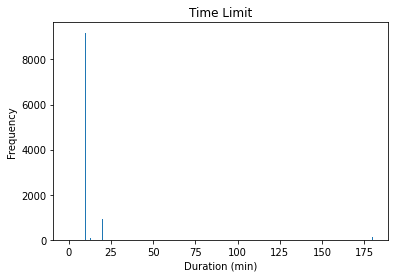

In [35]:
plt.hist(df_chess['time_limit'], bins='fd')
plt.title('Time Limit')
plt.xlabel('Duration (min)')
plt.ylabel('Frequency')
plt.show()

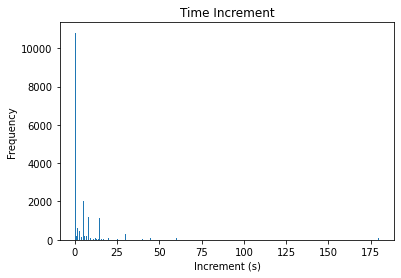

In [36]:
plt.hist(df_chess['time_increment'], bins='fd')
plt.title('Time Increment')
plt.xlabel('Increment (s)')
plt.ylabel('Frequency')
plt.show()

There are games where $\text{time_limit}=0$ or $\text{time_increment}=0$. But is there any game where both $=0$?

In [37]:
(df_chess[['time_limit', 'time_increment']] == 0).all(axis='columns').any()

False

Phew! No, there isn't. That's good.

It's possible to customize a game's timing in Lichess.org. Some of the standard game formats may also last a few hours. However, given that $\text{1 hour}=\text{60 minutes}$, some of those games could be out of place.

So, are there any outliers?

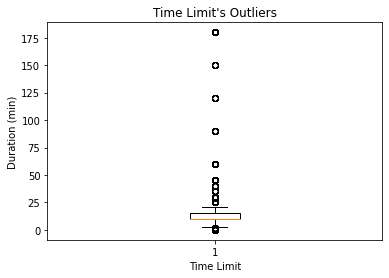

In [38]:
plt.boxplot(df_chess['time_limit'])
plt.title("Time Limit's Outliers")
plt.xlabel('Time Limit')
plt.ylabel('Duration (min)')
plt.show()

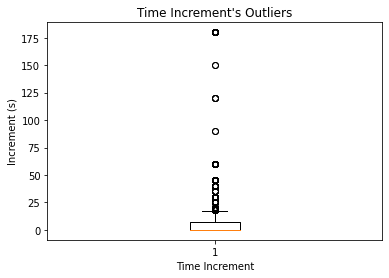

In [39]:
plt.boxplot(df_chess['time_increment'])
plt.title("Time Increment's Outliers")
plt.xlabel('Time Increment')
plt.ylabel('Increment (s)')
plt.show()

Might as well remove those outliers later on.

#### `white_id` and `black_id`

A player ID should be unique and not blank, nor empty. Since the same player can play multiple games, we can't check if they're really unique. But we can check if any of them is blank or empty.

In [40]:
not df_chess['white_id'].str.strip().apply(bool).all()

False

In [41]:
not df_chess['black_id'].str.strip().apply(bool).all()

False

No blank or empty player IDs.

A chess game should be played by two different players. Games with the same person playing as both sides are not valid for our analysis. Is there any game like that? That is, is there any game where `white_id == black_id`?

In [42]:
filt_games_same_player = (df_chess['white_id'] == df_chess['black_id'])

df_chess[filt_games_same_player].head()

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply,game_duration,time_limit,time_increment
9521,rZDhnp9r,True,2014-05-07 07:47:55.625,2014-05-07 07:49:00.534,4,resign,white,180+180,qwertygotousakorea,1240,qwertygotousakorea,1240,e4 e5 f3 d5,C20,King's Pawn Game: King's Head Opening #2,3,64909.0,180.0,180.0
10379,Pwtfvumx,False,2014-03-19 22:31:18.436,2014-03-19 22:36:01.024,8,resign,white,5+8,redwood,1678,redwood,1678,e3 e6 Qh5 g6 Qh3 Qh4 Qg4 Qxg4,A00,Van't Kruijs Opening,1,282588.0,5.0,8.0


We're removing those games form the dataset.

In [43]:
df_chess = df_chess[~filt_games_same_player]

#### `white_rating` and `black_rating`

The rating is a measure of a player's skill, and it seems to be used for the purpose of match-making. The higher the rating, the more victories that player achieved, and the opposite is also true.

In [44]:
df_chess[['white_rating', 'black_rating']].describe()

,white_rating,black_rating
count,19427.000000,19427.000000
mean,1597.712153,1589.919236
std,288.141021,288.830099
min,784.000000,789.000000
25%,1401.000000,1395.000000
50%,1568.000000,1563.000000
75%,1792.000000,1784.000000
max,2700.000000,2621.000000


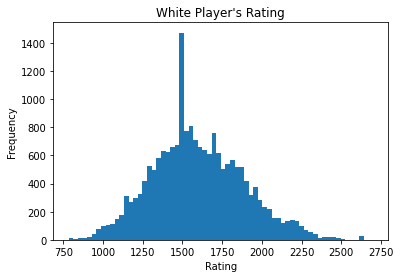

In [45]:
plt.hist(df_chess['white_rating'], bins='fd')
plt.title("White Player's Rating")
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

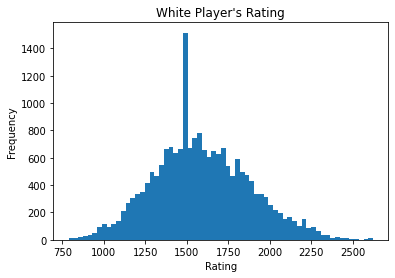

In [46]:
plt.hist(df_chess['black_rating'], bins='fd')
plt.title("White Player's Rating")
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

The values and the distributions of the ratings for both sides seem quite similar.

If we are to seek any outliers among the players based on their ratings, I believe we should do so considering the overall rating for all observed players. That is, we should seek for outliers considering the combination of both the _white_ and the _black_ players' ratings.

In [47]:
all_players_rating = pd.concat([
  df_chess['white_rating'],
  df_chess['black_rating']
])

In [48]:
all_players_rating.describe()

count    38854.000000
mean      1593.815695
std        288.508367
min        784.000000
25%       1398.000000
50%       1565.000000
75%       1788.000000
max       2700.000000
dtype: float64

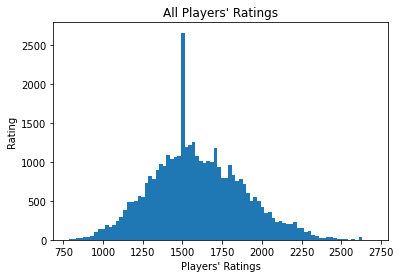

In [49]:
plt.hist(all_players_rating, bins='fd')
plt.title("All Players' Ratings")
plt.xlabel("Players' Ratings")
plt.ylabel('Rating')
plt.show()

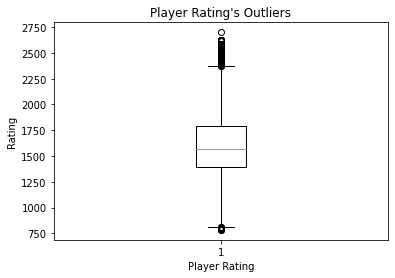

In [50]:
plt.boxplot(all_players_rating)
plt.title("Player Rating's Outliers")
plt.xlabel('Player Rating')
plt.ylabel('Rating')
plt.show()

Only some minor outliers, but I won't bother with them. I'm look for significant outliers, with values outside of $3*\text{IQR}$, not $1.5*\text{IQR}$.

#### `moves`

As we've seen before, all games had at least `1` turn, which means all games should have at least `1` move. Rather, for all games, the number of moves should equal to the number of turns. Is that true?

In [51]:
df_chess['moves'] = df_chess['moves'].str.split()

In [52]:
(df_chess['moves'].apply(len) == df_chess['turns']).all()

True

Yes, it is.

Do all moves follow the Algebraic Notation?

In [53]:
# Landing positions are labeled as a combination of file (column) and
# rank (row), such as "a2", "e7", "g4", etc.
# 
# Except for pawns, each piece's movement is prefixed by its initial letter.
# - K = King
# - Q = Queen
# - B = Bishop
# - N = kNight
# - R = Rook
# For instance, "Bd4" means "bishop moving to d4."
# 
# Captures are represented by a "x" prefixing the landing position.
# - "Bxd4" = "bishop moving to d4 and making a capture."
# 
# The origin of the movement may also be included for the sake of
# disambiguation when two pieces of the same type could've done that same
# movement. It may take the form of the file, the rank or both before the
# destination.
# - If the "white" player has his knights on positions "e4" and "e8", one might
#   represent the movement of the knight on "e4" to "d6" with "N4d6".
# 
# The Castling move has a special representation:
# - "O-O" = Castling with king's side rook
# - "O-O-O" = Castling with queen's side rook
# 
# A mate is represented by a "+" sufixing the move, while a check-mate is
# represented by a "#" sufixing the move.
# - "Nf3+" = "mate with knight moving to f3"
# - "Bg4#" = "check-mate with bishop moving to g4"
# 
# A promotion -- when a player's pawn reaches the opponent's side of the board
# and it's exchanged for another piece except for a king or a pawn -- is
# represented by a "=", followed by the initial letter of the new piece,
# sufixing the landing position.
# - "b8=Q" = "promoting a pawn to a queen by moving it to b8"

MOVE_NOTATION_PATTERN = r'^((K|[QBNR]?[a-h]?[1-8]?)x?[a-h][1-8]|O-O(-O)?)(=[QBNR])?[+#]?$'

In [54]:
df_chess['moves']\
  .apply(
    lambda moves: [bool(re.match(MOVE_NOTATION_PATTERN, m)) for m in moves]
  )\
  .apply(all)\
  .all()

True

All moves in all games are in accordance to the Algebraic Notation. That's good for now. We can analyze each game's list of moves later on to seek for useful informations, such as the numbers of captured pieces, promotions and checks.

#### `opening_eco` and `opening_name`

If no game has `0` moves, then all games should have an opening sequence. Therefore, no game should have a blank or empty value for both `opening_eco` and `opening_name`. Is that so?

In [55]:
df_chess[['opening_eco', 'opening_name']]\
  .applymap(str.strip)\
  .applymap(bool)\
  .all(axis=None)

True

Every game has an opening sequence, even those with a single turn.

Both of these values describe the same information: the opening sequence. We'll probably need just one of them. But which one? It could be the one with the bigger diversity of values.

In [56]:
pd.DataFrame(
  data=[
    len(df_chess['opening_eco'].unique()),
    len(df_chess['opening_name'].unique())
  ],
  index=pd.Index(
    ['opening_eco', 'opening_name'],
    name='column'
  ),
  columns=['unique_values_count']
)

,unique_values_count
column,
opening_eco,365
opening_name,1476


The variable `opening_name` is the most diverse of the two, so we're keeping it.

In [57]:
df_chess.drop('opening_eco', axis='columns', inplace=True)

#### `opening_ply`

It's expected for the number of moves in the opening sequence to be $x\space|\space{1}\le{x}\le\text{Turns}$. Are all games within those parameters?

In [58]:
df_chess.apply(
  lambda row: 1 <= row['opening_ply'] <= row['turns'],
  axis='columns'
).all()

True

They are.

Is it worthwhile to check for outliers in this series?

In [59]:
df_chess[['opening_ply']].describe()

,opening_ply
count,19427.000000
mean,4.837288
std,2.788069
min,1.000000
25%,3.000000
50%,4.000000
75%,6.000000
max,28.000000


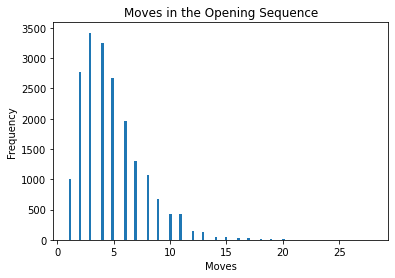

In [60]:
plt.hist(df_chess['opening_ply'], bins='fd')
plt.title("Moves in the Opening Sequence")
plt.xlabel('Moves')
plt.ylabel('Frequency')
plt.show()

All those values correspond to known opening sequences. That is, we could say it's a categorical information, and not a quantitative one. Therefore, I see no reason to seek for outliers.

### Exploring the Data

Here's our dataset so far.

In [61]:
df_chess.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19427 entries, 0 to 20057
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              19427 non-null  object        
 1   rated           19427 non-null  bool          
 2   created_at      19427 non-null  datetime64[ns]
 3   last_move_at    19427 non-null  datetime64[ns]
 4   turns           19427 non-null  int64         
 5   victory_status  19427 non-null  object        
 6   winner          19427 non-null  object        
 7   increment_code  19427 non-null  object        
 8   white_id        19427 non-null  object        
 9   white_rating    19427 non-null  int64         
 10  black_id        19427 non-null  object        
 11  black_rating    19427 non-null  int64         
 12  moves           19427 non-null  object        
 13  opening_name    19427 non-null  object        
 14  opening_ply     19427 non-null  int64         
 15  ga

#### Removing Outliers

We're starting by removing some outliers from the dataset, based on the following columns:

- `turns`;
- `time_limit`;
- `time_increment`;
- and `game_duration`.

We already know, from the intergrity assertion phase, that those columns may hold significant outliers. My criterion is to remove any outlier ${x}\space|$ not $(\text{1st Quartile}-{3}\times\text{IRQ})\le{x}\le(\text{3rd Quartile}+{3}\times\text{IRQ})$.

In [62]:
def series_non_outliers_filt(series):
  major_ol_limits = series.quantile([.25, .75])\
                    + np.array([-3, 3]) * stats.iqr(series)
  return series.apply(
    lambda value: major_ol_limits[.25] <= value <= major_ol_limits[.75]
  )

filt_non_outliers_keep = (
  series_non_outliers_filt(df_chess['turns']) &
  series_non_outliers_filt(df_chess['time_limit']) &
  series_non_outliers_filt(df_chess['time_increment']) &
  series_non_outliers_filt(df_chess['game_duration'])
)

print(f'{filt_non_outliers_keep.sum()} rows will be kept.')

17793 rows will be kept.


In [63]:
df_chess = df_chess[filt_non_outliers_keep]

And now `turns`, `time_limit`, `time_increment` and `game_duration` look like this:

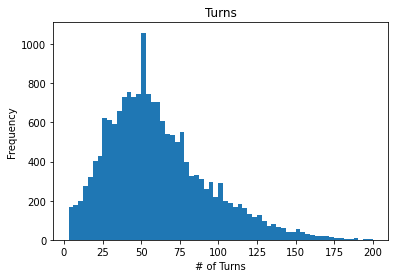

In [64]:
plt.hist(df_chess['turns'], bins='fd')
plt.title('Turns')
plt.xlabel('# of Turns')
plt.ylabel('Frequency')
plt.show()

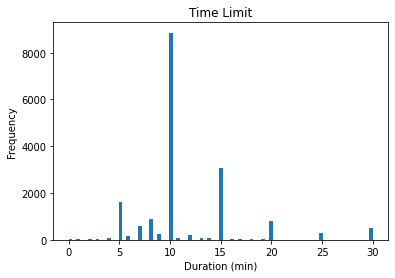

In [65]:
plt.hist(df_chess['time_limit'], bins='fd')
plt.title('Time Limit')
plt.xlabel('Duration (min)')
plt.ylabel('Frequency')
plt.show()

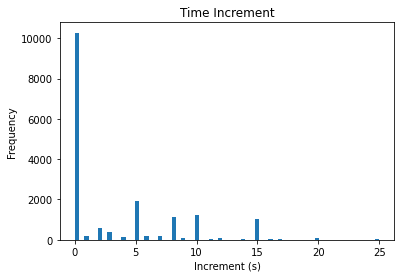

In [66]:
plt.hist(df_chess['time_increment'], bins='fd')
plt.title('Time Increment')
plt.xlabel('Increment (s)')
plt.ylabel('Frequency')
plt.show()

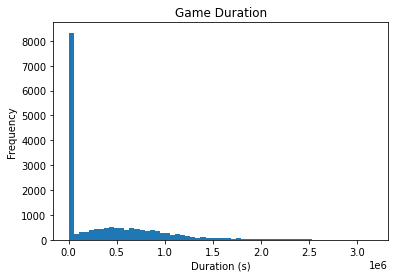

In [67]:
plt.hist(df_chess['game_duration'], bins='fd')
plt.title('Game Duration')
plt.xlabel('Duration (s)')
plt.ylabel('Frequency')
plt.show()

#### Seeking Correlations

Now we need to find some useful correlations between our independent variables and the dependent variable (`winner`).

If we look closely to the dataset, we notice that victory can be achieved by different means:

- by mate;
- if the opponent runs out of time;
- if the opponent resigns.

Let's not forget the possibility of a tie, that happens when:

- the same positioning of pieces shows up a third time;
- a player runs out of time but his opponent hasn't enoguh pieces to win by mate.

Those are fairly different situations that might occur during a game, and they could help us identify its outcome more precisely. However, this is an information that can only be gathered by the end of the game, and we're developing a classification model considering its application on active games. We could say that the victory condition is itself a dependent variable, and thus is of no use to us in this project.

The games' duration may also be of no use to our classification model, since it's the sum of the elapsed times from the timers of both players. Also, $\frac{1}{4}$ of the games lasted for `0 s` -- or so says the starting and ending timestamps, which might be due to some error. It could be helpful if we had the elapsed time of each player's timer. But that's not the case this time, so we move on.

I believe we can find some useful informations exploring the following columns:

- `rated`;
- `turns`;
- `time_limit`;
- `time_increment`;
- `white_rating`;
- `black_rating`;
- and `moves`.

I'm defining functions to test for equality among two or more series, and dependency between populations. They'll help in the exploratory analysis.

In [68]:
def test_series_equality(*series, paired=False):
  """Tests for equality of both variances and means of a group of series."""

  # Test for equality of variances.
  # H0: var(x1) = var(x2) = ...
  # H1: At least two variances are different from each other.
  # Alpha = 5%
  same_variances = stats.levene(*series).pvalue > .05

  pv_means_test = .0

  # Test for normality.
  # H0: The sample fits the normal distribution model.
  # H1: The sample could be explained by a different distribution model.
  # Alpha = 5%
  if all(stats.kstest(s, 'norm').pvalue > .05 for s in series):
    # Test for equality of means...
    if len(series > 2):
      # ... with One-Way ANOVA.
      # H0: mean(x1) = mean(x2) = ...
      # H1: At least two means are different from each other.
      # Alpha = 5%
      pv_means_test = stats.f_oneway(*series).pvalue
    else:
      # ... with Student's t-Test.
      # H0: mean(x) = mean(y).
      # H1: mean(x) is NOT equal to mean(y).
      # Alpha = 5%
      if paired:
        pv_means_test = stats.ttest_rel(*series).pvalue
      else:
        pv_means_test = stats.ttest_ind(*series).pvalue
  else:
    # Test for equality of means...
    if len(series) > 2:
      # ... with Kruskal-Wallis' Test.
      # H0: mean(x1) = mean(x2) = ...
      # H1: At least two means are different from each other.
      # Alpha = 5%
      pv_means_test = stats.kruskal(*series).pvalue
    else:
      # ... with either Wilcoxon's or Mann-Whitney's Test.
      # H0: mean(x) = mean(y).
      # H1: mean(x) is NOT equal to mean(y).
      # Alpha = 5%
      if paired:
        pv_means_test = stats.wilcoxon(*series).pvalue
      else:
        pv_means_test = stats.mannwhitneyu(*series, alternative='two-sided').pvalue
        
  return same_variances and pv_means_test > .05

In [69]:
def test_populations_dependency(rows, columns):
  """Tests for dependency between two populations using Chi-Square."""

  # Test for independency between populations using Chi-Square Contigency Table.
  # H0: The two populations are independent.
  # H1: The two populations are dependent somehow.
  # Alpha = 5%
  return (stats.chi2_contingency(pd.crosstab(rows, columns))[1] <= .05)

##### Does the game being rated have any influence over the outcome?

Perhaps the players take the games more seriuously when it is rated than when it isn't. Perhaps a game being rated or not makes no difference.

In [70]:
pd.crosstab(
  df_chess['rated'],
  df_chess['winner'],
  normalize='all',
  margins=True
)

winner,black,draw,white,All
rated,,,,
False,0.08228,0.008655,0.091216,0.18215
True,0.37363,0.034564,0.409655,0.81785
All,0.45591,0.043219,0.500871,1.00000


Are those columns dependent somehow?

In [71]:
test_populations_dependency(df_chess['rated'], df_chess['winner'])

False

No, they aren't. Which means that it makes no difference for the outcome whether a game is rated or not.

##### Does the number of turns have any influence in the outcome?

Is there any relationship between the number of turns and the outcome of a game? Sounds unlikely, but one can't be sure without any tests. Perhaps the higher the number of turns played, the higher is the chance of a draw? Perhaps it's the other way around?

In [72]:
grp_turns_by_outcome = df_chess.groupby('winner')['turns']

white_winner_turns = grp_turns_by_outcome.get_group('white')
black_winner_turns = grp_turns_by_outcome.get_group('black')
draw_turns = grp_turns_by_outcome.get_group('draw')

In [73]:
pd.DataFrame({
  'white': white_winner_turns.describe(),
  'black': black_winner_turns.describe(),
  'draw': draw_turns.describe()
}).rename_axis(index='stat', columns='outcome')

outcome,white,black,draw
stat,,,
count,8912.000000,8112.000000,769.000000
mean,57.872756,61.092579,86.283485
std,31.221537,31.586734,43.765595
min,3.000000,3.000000,3.000000
25%,35.000000,38.750000,50.000000
50%,53.000000,56.000000,91.000000
75%,75.000000,78.000000,117.000000
max,193.000000,200.000000,200.000000


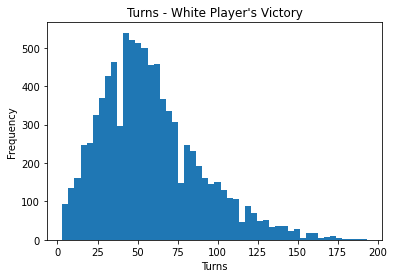

In [74]:
plt.hist(white_winner_turns, bins='fd')
plt.title("Turns - White Player's Victory")
plt.xlabel('Turns')
plt.ylabel('Frequency')
plt.show()

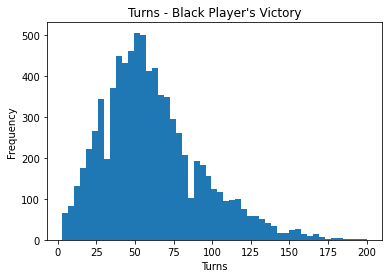

In [75]:
plt.hist(black_winner_turns, bins='fd')
plt.title("Turns - Black Player's Victory")
plt.xlabel('Turns')
plt.ylabel('Frequency')
plt.show()

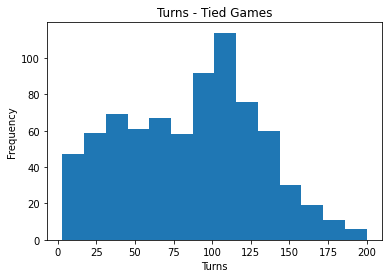

In [76]:
plt.hist(draw_turns, bins='fd')
plt.title("Turns - Tied Games")
plt.xlabel('Turns')
plt.ylabel('Frequency')
plt.show()

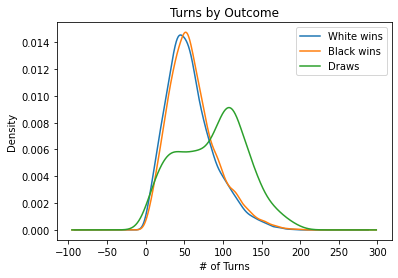

In [77]:
white_winner_turns.plot.density()
black_winner_turns.plot.density()
draw_turns.plot.density()
plt.title("Turns by Outcome")
plt.xlabel('# of Turns')
plt.legend(['White wins', 'Black wins', 'Draws'])
plt.show()

Are those groups equal to each other?

In [78]:
test_series_equality(
  white_winner_turns,
  black_winner_turns,
  draw_turns
)

False

No, they aren't. So at least one of them might stand out from the other outcomes.

In [79]:
filt_games_white_won = (df_chess['winner'] == 'white')
filt_games_black_won = (df_chess['winner'] == 'black')
filt_games_tied = (df_chess['winner'] == 'draw')

In [80]:
# 'white' vs. Rest
test_series_equality(
  df_chess['turns'][filt_games_white_won],
  df_chess['turns'][~filt_games_white_won]
)

False

In [81]:
# 'black' vs. Rest
test_series_equality(
  df_chess['turns'][filt_games_black_won],
  df_chess['turns'][~filt_games_black_won]
)

False

In [82]:
# 'draw' vs. Rest
test_series_equality(
  df_chess['turns'][filt_games_tied],
  df_chess['turns'][~filt_games_tied]
)

False

It seems the number of turns might help distinguish the possible outcomes of a game.

The distributions seem similar for games where either player won. But are they equal to each other?

In [83]:
# 'white' vs. 'black'
test_series_equality(
  white_winner_turns,
  black_winner_turns
)

False

No, they're different, although possibly not by much.

##### Does the time limit have any influence in the outcome?

Is it possible that either a higher or a lower time limit helps or hinders any particular side? Or perhaps the lower the time limit, the lower the chance of a draw?

In [84]:
white_winner_time_limit = df_chess['time_limit'][filt_games_white_won]
black_winner_time_limit = df_chess['time_limit'][filt_games_black_won]
draw_time_limit = df_chess['time_limit'][filt_games_tied]

In [85]:
pd.DataFrame({
  'white': white_winner_time_limit.describe(),
  'black': black_winner_time_limit.describe(),
  'draw': draw_time_limit.describe()
}).rename_axis(index='stat', columns='outcome')

outcome,white,black,draw
stat,,,
count,8912.000000,8112.000000,769.000000
mean,11.441876,11.378452,11.780234
std,5.079879,5.068707,5.146532
min,0.000000,0.000000,0.000000
25%,10.000000,10.000000,10.000000
50%,10.000000,10.000000,10.000000
75%,15.000000,15.000000,15.000000
max,30.000000,30.000000,30.000000


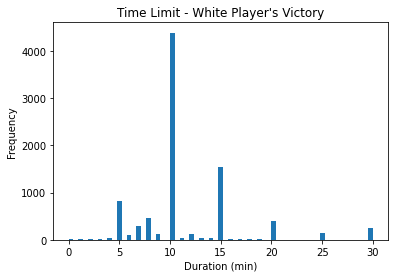

In [86]:
plt.hist(white_winner_time_limit, bins='fd')
plt.title("Time Limit - White Player's Victory")
plt.xlabel('Duration (min)')
plt.ylabel('Frequency')
plt.show()

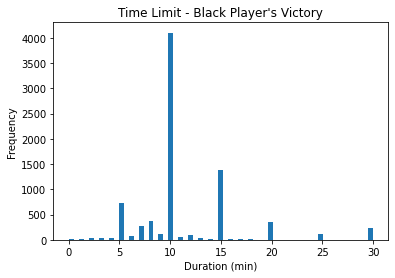

In [87]:
plt.hist(black_winner_time_limit, bins='fd')
plt.title("Time Limit - Black Player's Victory")
plt.xlabel('Duration (min)')
plt.ylabel('Frequency')
plt.show()

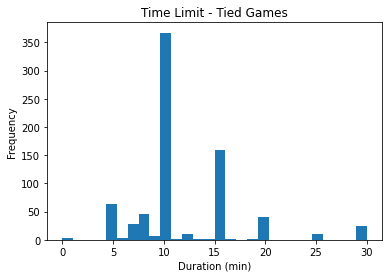

In [88]:
plt.hist(draw_time_limit, bins='fd')
plt.title("Time Limit - Tied Games")
plt.xlabel('Duration (min)')
plt.ylabel('Frequency')
plt.show()

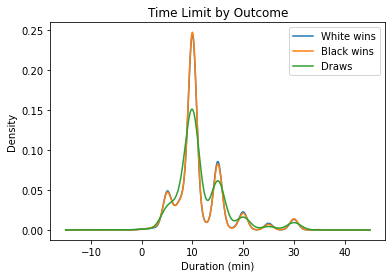

In [89]:
white_winner_time_limit.plot.density()
black_winner_time_limit.plot.density()
draw_time_limit.plot.density()
plt.title('Time Limit by Outcome')
plt.xlabel('Duration (min)')
plt.legend(['White wins', 'Black wins', 'Draws'])
plt.show()

Are those groups equal to each other?

In [90]:
test_series_equality(
  white_winner_time_limit,
  black_winner_time_limit,
  draw_time_limit
)

True

Interesting. The groups are statistically equal. So the time limit doesn't seem to favor any particular outcome. We won't be extracting a feature from this column.

##### Does the time increment have any influence in the outcome?

Does the time increment favor any outcome? Considering that the time limit didn't, it may be the same for the time increment.

In [91]:
white_winner_time_incr = df_chess['time_increment'][filt_games_white_won]
black_winner_time_incr = df_chess['time_increment'][filt_games_black_won]
draw_time_incr = df_chess['time_increment'][filt_games_tied]

In [92]:
pd.DataFrame({
  'white': white_winner_time_incr.describe(),
  'black': black_winner_time_incr.describe(),
  'draw': draw_time_incr.describe()
}).rename_axis(index='stat', columns='outcome')

outcome,white,black,draw
stat,,,
count,8912.000000,8112.000000,769.000000
mean,3.360525,3.307446,3.690507
std,4.942659,4.870702,5.138998
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,5.000000,5.000000,7.000000
max,25.000000,25.000000,25.000000


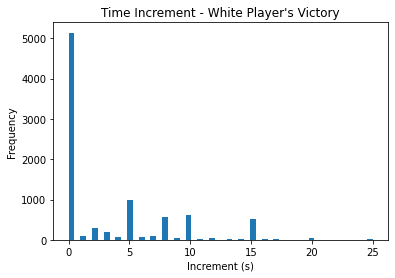

In [93]:
plt.hist(white_winner_time_incr, bins='fd')
plt.title("Time Increment - White Player's Victory")
plt.xlabel('Increment (s)')
plt.ylabel('Frequency')
plt.show()

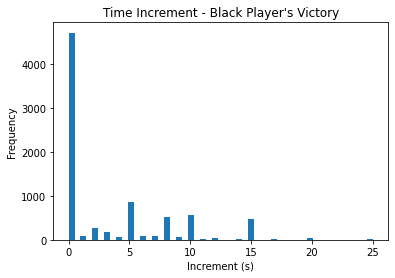

In [94]:
plt.hist(black_winner_time_incr, bins='fd')
plt.title("Time Increment - Black Player's Victory")
plt.xlabel('Increment (s)')
plt.ylabel('Frequency')
plt.show()

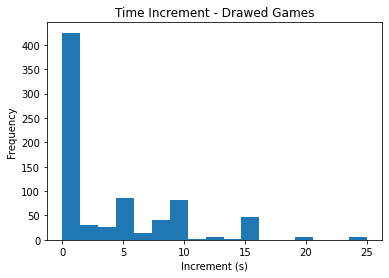

In [95]:
plt.hist(draw_time_incr, bins='fd')
plt.title("Time Increment - Drawed Games")
plt.xlabel('Increment (s)')
plt.ylabel('Frequency')
plt.show()

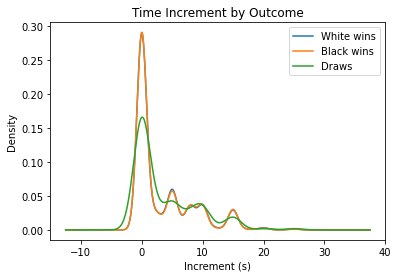

In [96]:
white_winner_time_incr.plot.density()
black_winner_time_incr.plot.density()
draw_time_incr.plot.density()
plt.title('Time Increment by Outcome')
plt.xlabel('Increment (s)')
plt.legend(['White wins', 'Black wins', 'Draws'])
plt.show()

Are those groups equal to each other?

In [97]:
test_series_equality(
  white_winner_time_incr,
  black_winner_time_incr,
  draw_time_incr
)

True

Yes, they are. Which means that the time increment won't help us distinguish an outcome from another.

##### Does the players' rating have any influence in the outcome?

Does the player's rating alone have any influence on the outcome? I'm guessing so, but I believe it may prove to be more effective to assess the .

In [98]:
white_winner_rating = df_chess['white_rating'][filt_games_white_won]
white_loser_rating = df_chess['white_rating'][filt_games_black_won]
white_draw_rating = df_chess['white_rating'][filt_games_tied]

black_winner_rating = df_chess['black_rating'][filt_games_black_won]
black_loser_rating = df_chess['black_rating'][filt_games_white_won]
black_draw_rating = df_chess['black_rating'][filt_games_tied]

In [99]:
pd.DataFrame({
  'white wins': white_winner_rating.describe(),
  'white loses': white_loser_rating.describe(),
  'white draws': white_draw_rating.describe()
}).rename_axis(index='stat', columns='outcome')

outcome,white wins,white loses,white draws
stat,,,
count,8912.000000,8112.000000,769.000000
mean,1632.455566,1550.531805,1637.798440
std,283.891082,276.119778,300.298943
min,784.000000,788.000000,907.000000
25%,1441.000000,1357.000000,1430.000000
50%,1603.000000,1528.000000,1614.000000
75%,1818.250000,1737.000000,1838.000000
max,2622.000000,2621.000000,2524.000000


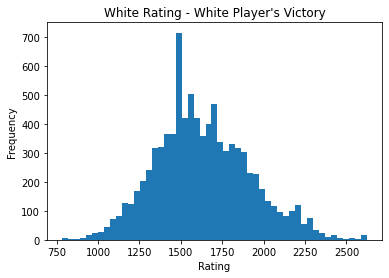

In [100]:
plt.hist(white_winner_rating, bins='fd')
plt.title("White Rating - White Player's Victory")
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

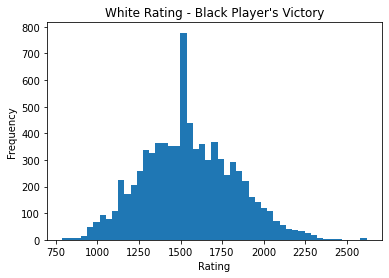

In [101]:
plt.hist(white_loser_rating, bins='fd')
plt.title("White Rating - Black Player's Victory")
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

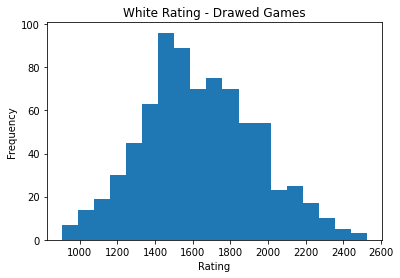

In [102]:
plt.hist(white_draw_rating, bins='fd')
plt.title("White Rating - Drawed Games")
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

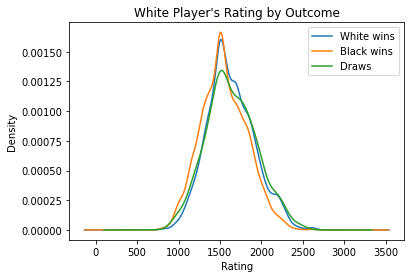

In [103]:
white_winner_rating.plot.density()
white_loser_rating.plot.density()
white_draw_rating.plot.density()
plt.title("White Player's Rating by Outcome")
plt.xlabel('Rating')
plt.legend(['White wins', 'Black wins', 'Draws'])
plt.show()

In [104]:
pd.DataFrame({
  'black wins': black_winner_rating.describe(),
  'black loses': black_loser_rating.describe(),
  'black draws': black_draw_rating.describe()
}).rename_axis(index='stat', columns='outcome')

outcome,black wins,black loses,black draws
stat,,,
count,8112.000000,8912.000000,769.000000
mean,1637.320759,1540.309134,1633.940182
std,285.796875,276.909171,298.195592
min,789.000000,795.000000,869.000000
25%,1441.000000,1350.000000,1440.000000
50%,1608.000000,1517.000000,1626.000000
75%,1826.000000,1726.000000,1829.000000
max,2621.000000,2621.000000,2526.000000


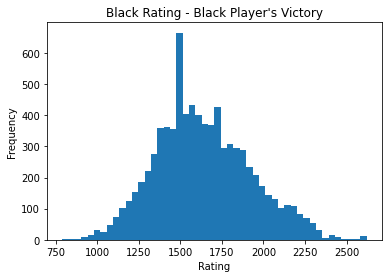

In [105]:
plt.hist(black_winner_rating, bins='fd')
plt.title("Black Rating - Black Player's Victory")
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

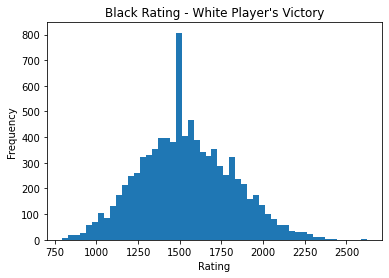

In [106]:
plt.hist(black_loser_rating, bins='fd')
plt.title("Black Rating - White Player's Victory")
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

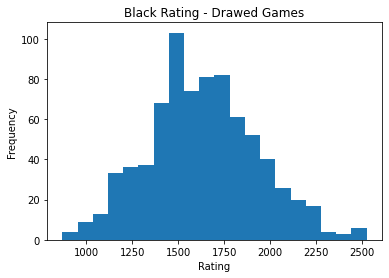

In [107]:
plt.hist(black_draw_rating, bins='fd')
plt.title("Black Rating - Drawed Games")
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

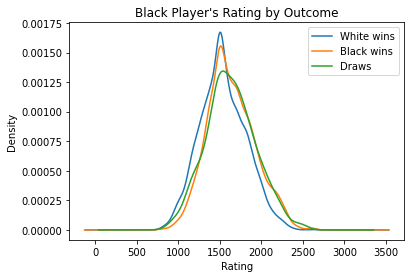

In [108]:
black_loser_rating.plot.density()
black_winner_rating.plot.density()
black_draw_rating.plot.density()
plt.title("Black Player's Rating by Outcome")
plt.xlabel('Rating')
plt.legend(['White wins', 'Black wins', 'Draws'])
plt.show()

Are all the _white_ player's rating groups equal to each other?

In [109]:
test_series_equality(
  white_winner_rating,
  white_loser_rating,
  white_draw_rating
)

False

No, they aren't. Does any of them help us distinguish the outcomes?

In [110]:
# 'white' vs. Rest
test_series_equality(
  white_winner_rating,
  df_chess['white_rating'][~filt_games_white_won]
)

False

In [111]:
# 'black' vs. Rest
test_series_equality(
  white_loser_rating,
  df_chess['white_rating'][~filt_games_black_won]
)

False

In [112]:
# 'draw' vs. Rest
test_series_equality(
  white_draw_rating,
  df_chess['white_rating'][~filt_games_tied]
)

False

Yes, they do. We can extract a feature from the _white_ player's rating.

Are all the _black_ player's rating groups equal to each other?

In [113]:
test_series_equality(
  black_winner_rating,
  black_loser_rating,
  black_draw_rating
)

False

No, they aren't. Does any of them help us distinguish the outcomes?

In [114]:
# 'black' vs. Rest
test_series_equality(
  black_winner_rating,
  df_chess['black_rating'][~filt_games_black_won]
)

False

In [115]:
# 'white' vs. Rest
test_series_equality(
  black_loser_rating,
  df_chess['black_rating'][~filt_games_white_won]
)

False

In [116]:
# 'draw' vs. Rest
test_series_equality(
  black_draw_rating,
  df_chess['black_rating'][~filt_games_tied]
)

False

Yes, they do. We can extract a feature from the _black_ player's rating.

##### Does the gap between the players' ratings influence their chance of victory?

This is something I'd like to explore. What if the difference between the players' ratings is more effective than the ratings themselves?

We could define the gap between two players' ratings as the difference between the _white_ player's rating and the _black_ player's. A margin that favors the _white_ player will be positive ($\gt{0}$) while a margin that favors the _black_ player will be negative ($\lt{0}$). A prefectly neutral margin would be null ($={0}$).

In [117]:
df_chess['rating_gap'] = (df_chess['white_rating'] - df_chess['black_rating'])

In [118]:
df_chess[['rating_gap']].describe()

,rating_gap
count,17793.000000
mean,6.752318
std,241.298721
min,-1605.000000
25%,-104.000000
50%,3.000000
75%,117.000000
max,1499.000000


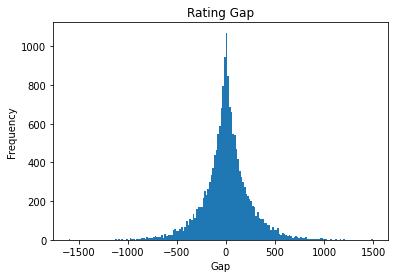

In [119]:
plt.hist(df_chess['rating_gap'], bins='fd')
plt.title('Rating Gap')
plt.xlabel('Gap')
plt.ylabel('Frequency')
plt.show()

We could compare those gaps grouped by outcome to see if they really make any difference.

In [120]:
white_winner_rating_gap = df_chess['rating_gap'][filt_games_white_won]
black_winner_rating_gap = df_chess['rating_gap'][filt_games_black_won]
draw_rating_gap = df_chess['rating_gap'][filt_games_tied]

In [121]:
pd.DataFrame({
  'white': white_winner_rating_gap.describe(),
  'black': black_winner_rating_gap.describe(),
  'draw': draw_rating_gap.describe()
}).rename_axis(index='stat', columns='outcome')

outcome,white,black,draw
stat,,,
count,8912.000000,8112.000000,769.000000
mean,92.146432,-86.788955,3.858257
std,226.720745,225.181370,199.736563
min,-1121.000000,-1605.000000,-810.000000
25%,-32.000000,-195.000000,-95.000000
50%,57.000000,-50.000000,-3.000000
75%,201.000000,36.250000,86.000000
max,1499.000000,1008.000000,1024.000000


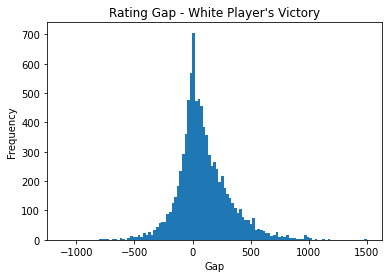

In [122]:
plt.hist(white_winner_rating_gap, bins='fd')
plt.title("Rating Gap - White Player's Victory")
plt.xlabel('Gap')
plt.ylabel('Frequency')
plt.show()

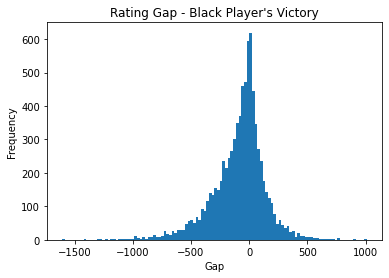

In [123]:
plt.hist(black_winner_rating_gap, bins='fd')
plt.title("Rating Gap - Black Player's Victory")
plt.xlabel('Gap')
plt.ylabel('Frequency')
plt.show()

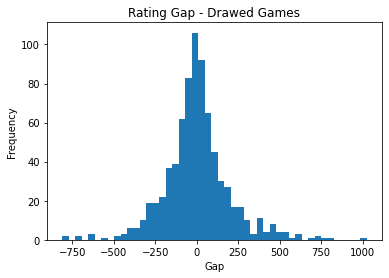

In [124]:
plt.hist(draw_rating_gap, bins='fd')
plt.title("Rating Gap - Drawed Games")
plt.xlabel('Gap')
plt.ylabel('Frequency')
plt.show()

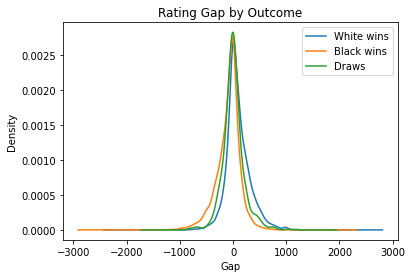

In [125]:
white_winner_rating_gap.plot.density()
black_winner_rating_gap.plot.density()
draw_rating_gap.plot.density()
plt.title('Rating Gap by Outcome')
plt.xlabel('Gap')
plt.legend(['White wins', 'Black wins', 'Draws'])
plt.show()

Those distributions are very similar. However, we can see that the distributions for games where any of the players won are asymmetrical. Gaps favoring their respective sides (positive gaps for the _white_ player, negative for the _black_ player) are prevalent. Perhaps the chances of victory when a gap favors the player are different from when it's against them.

Can we highlight that asymmetry? What if we square the individual ratings, calculate the gap, and then take the square root?

In [126]:
diff_of_squares = (df_chess['white_rating'] ** 2\
                   - df_chess['black_rating'] ** 2)

df_chess['rating_gap'] = np.sign(diff_of_squares)\
                         * diff_of_squares.abs() ** (1 / 2)

In [127]:
df_chess[['rating_gap']].describe()

,rating_gap
count,17793.000000
mean,20.605990
std,733.218737
min,-2416.068087
25%,-569.893850
50%,89.078617
75%,606.815458
max,2368.703654


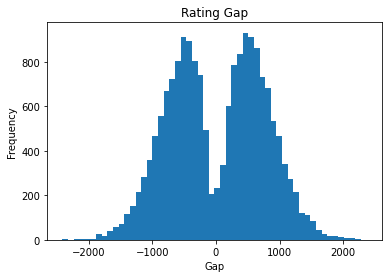

In [128]:
plt.hist(df_chess['rating_gap'], bins='fd')
plt.title('Rating Gap')
plt.xlabel('Gap')
plt.ylabel('Frequency')
plt.show()

That's interesting.

In [129]:
white_winner_rating_gap = df_chess['rating_gap'][filt_games_white_won]
black_winner_rating_gap = df_chess['rating_gap'][filt_games_black_won]
draw_rating_gap = df_chess['rating_gap'][filt_games_tied]

In [130]:
pd.DataFrame({
  'white': white_winner_rating_gap.describe(),
  'black': black_winner_rating_gap.describe(),
  'draw': draw_rating_gap.describe()
}).rename_axis(index='stat', columns='outcome')

outcome,white,black,draw
stat,,,
count,8912.000000,8112.000000,769.000000
mean,284.230495,-266.776740,-3.025857
std,680.895951,684.023845,674.151423
min,-2149.335013,-2416.068087,-1767.306425
25%,-314.874929,-780.637629,-542.240721
50%,418.913475,-391.148948,-93.610897
75%,790.612412,337.268411,533.471649
max,2368.703654,2065.882862,2029.920195


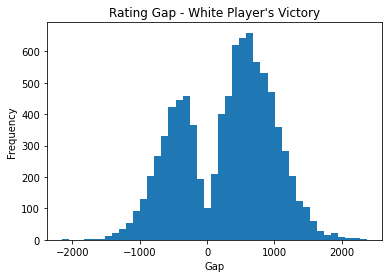

In [131]:
plt.hist(white_winner_rating_gap, bins='fd')
plt.title("Rating Gap - White Player's Victory")
plt.xlabel('Gap')
plt.ylabel('Frequency')
plt.show()

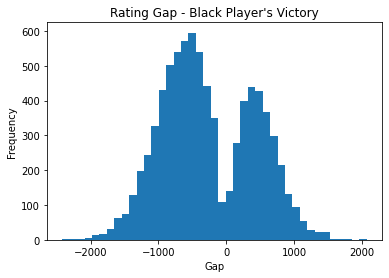

In [132]:
plt.hist(black_winner_rating_gap, bins='fd')
plt.title("Rating Gap - Black Player's Victory")
plt.xlabel('Gap')
plt.ylabel('Frequency')
plt.show()

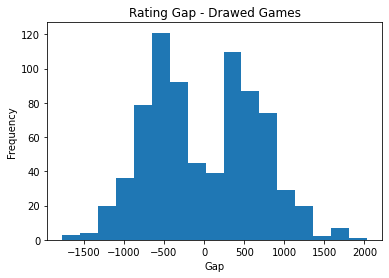

In [133]:
plt.hist(draw_rating_gap, bins='fd')
plt.title("Rating Gap - Drawed Games")
plt.xlabel('Gap')
plt.ylabel('Frequency')
plt.show()

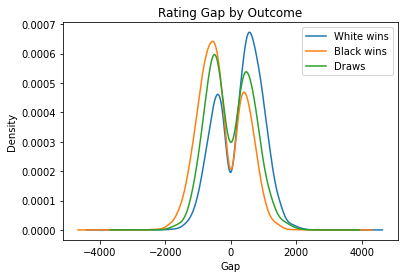

In [134]:
white_winner_rating_gap.plot.density()
black_winner_rating_gap.plot.density()
draw_rating_gap.plot.density()
plt.title('Rating Gap by Outcome')
plt.xlabel('Gap')
plt.legend(['White wins', 'Black wins', 'Draws'])
plt.show()

Now we have a clearer distinction between gaps that favor or play against each player. We can go even further by splitting the rating gaps as gaps favoring the _white_ player, gaps favoring the _black_ player, and neutral gaps.

In [135]:
df_chess['rating_gap_white'] = df_chess['rating_gap']\
  .apply(lambda x: x if x > .0 else .0)

df_chess['rating_gap_black'] = df_chess['rating_gap']\
  .apply(lambda x: -x if x < .0 else .0)

df_chess['rating_gap_neutral'] = (df_chess['rating_gap'] == .0)

In [136]:
df_chess[['rating_gap_white', 'rating_gap_black']].describe()

,rating_gap_white,rating_gap_black
count,17793.000000,17793.000000
mean,329.739905,309.133915
std,412.883723,404.051623
min,0.000000,0.000000
25%,0.000000,0.000000
50%,89.078617,0.000000
75%,606.815458,569.893850
max,2368.703654,2416.068087


In [137]:
pd.DataFrame(df_chess['rating_gap_neutral'].value_counts())

,rating_gap_neutral
False,17623
True,170


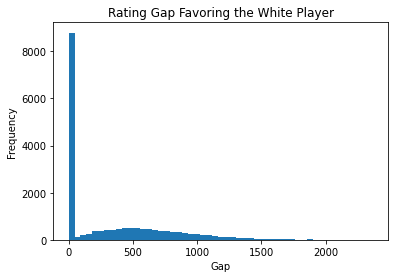

In [138]:
plt.hist(df_chess['rating_gap_white'], bins='fd')
plt.title('Rating Gap Favoring the White Player')
plt.xlabel('Gap')
plt.ylabel('Frequency')
plt.show()

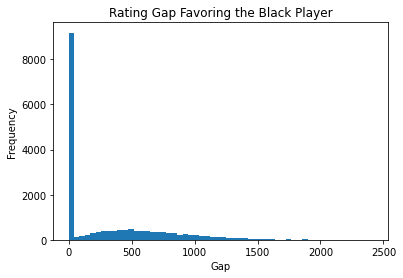

In [139]:
plt.hist(df_chess['rating_gap_black'], bins='fd')
plt.title('Rating Gap Favoring the Black Player')
plt.xlabel('Gap')
plt.ylabel('Frequency')
plt.show()

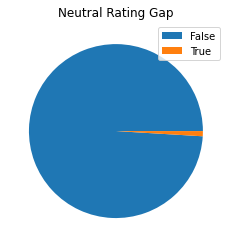

In [140]:
plt.pie(df_chess['rating_gap_neutral'].value_counts())
plt.title('Neutral Rating Gap')
plt.legend(df_chess['rating_gap_neutral'].value_counts().keys())
plt.show()

But will those new columns help us distinguish the outcomes of the game?

In [141]:
white_winner_white_gap = df_chess['rating_gap_white'][filt_games_white_won]
black_winner_white_gap = df_chess['rating_gap_white'][filt_games_black_won]
draw_white_gap = df_chess['rating_gap_white'][filt_games_tied]

white_winner_black_gap = df_chess['rating_gap_black'][filt_games_white_won]
black_winner_black_gap = df_chess['rating_gap_black'][filt_games_black_won]
draw_black_gap = df_chess['rating_gap_black'][filt_games_tied]

white_winner_neutral_gap = df_chess['rating_gap_neutral'][filt_games_white_won]
black_winner_neutral_gap = df_chess['rating_gap_neutral'][filt_games_black_won]
draw_neutral_gap = df_chess['rating_gap_neutral'][filt_games_tied]

In [142]:
pd.DataFrame({
  'white': white_winner_white_gap.describe(),
  'black': black_winner_white_gap.describe(),
  'draw': draw_white_gap.describe()
}).rename_axis(index='stat', columns='outcome')

outcome,white,black,draw
stat,,,
count,8912.000000,8112.000000,769.000000
mean,463.787161,185.995397,292.582942
std,453.032675,306.372236,385.327986
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,418.913475,0.000000,0.000000
75%,790.612412,337.268411,533.471649
max,2368.703654,2065.882862,2029.920195


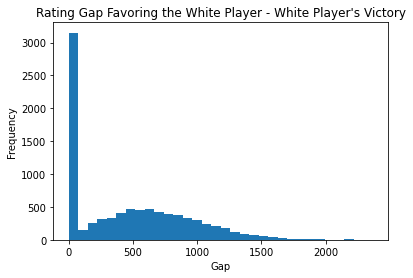

In [143]:
plt.hist(white_winner_white_gap, bins='fd')
plt.title("Rating Gap Favoring the White Player - White Player's Victory")
plt.xlabel('Gap')
plt.ylabel('Frequency')
plt.show()

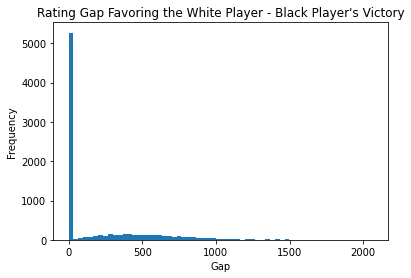

In [144]:
plt.hist(black_winner_white_gap, bins='fd')
plt.title("Rating Gap Favoring the White Player - Black Player's Victory")
plt.xlabel('Gap')
plt.ylabel('Frequency')
plt.show()

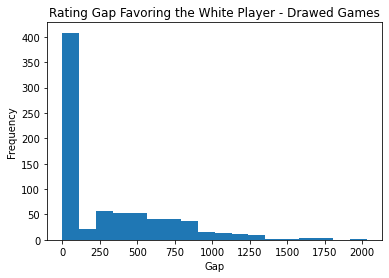

In [145]:
plt.hist(draw_white_gap, bins='fd')
plt.title("Rating Gap Favoring the White Player - Drawed Games")
plt.xlabel('Gap')
plt.ylabel('Frequency')
plt.show()

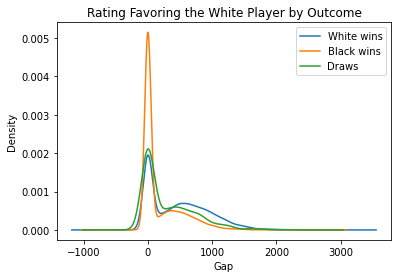

In [146]:
white_winner_white_gap.plot.density()
black_winner_white_gap.plot.density()
draw_white_gap.plot.density()
plt.title('Rating Favoring the White Player by Outcome')
plt.xlabel('Gap')
plt.legend(['White wins', 'Black wins', 'Draws'])
plt.show()

In [147]:
pd.DataFrame({
  'white': white_winner_black_gap.describe(),
  'black': black_winner_black_gap.describe(),
  'draw': draw_black_gap.describe()
}).rename_axis(index='stat', columns='outcome')

outcome,white,black,draw
stat,,,
count,8912.000000,8112.000000,769.000000
mean,179.556666,452.772137,295.608800
std,303.001399,453.405824,364.413315
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,391.148948,93.610897
75%,314.874929,780.637629,542.240721
max,2149.335013,2416.068087,1767.306425


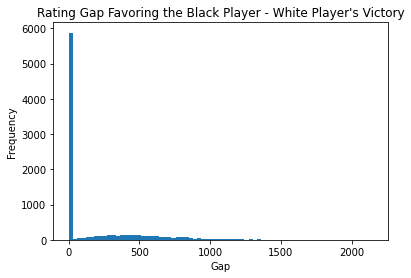

In [148]:
plt.hist(white_winner_black_gap, bins='fd')
plt.title("Rating Gap Favoring the Black Player - White Player's Victory")
plt.xlabel('Gap')
plt.ylabel('Frequency')
plt.show()

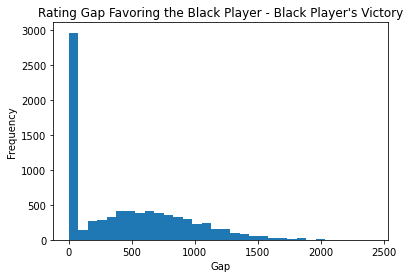

In [149]:
plt.hist(black_winner_black_gap, bins='fd')
plt.title("Rating Gap Favoring the Black Player - Black Player's Victory")
plt.xlabel('Gap')
plt.ylabel('Frequency')
plt.show()

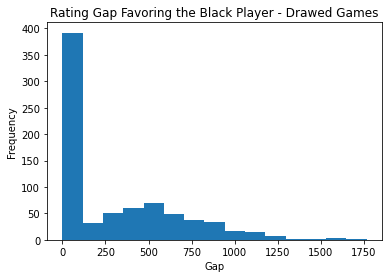

In [150]:
plt.hist(draw_black_gap, bins='fd')
plt.title("Rating Gap Favoring the Black Player - Drawed Games")
plt.xlabel('Gap')
plt.ylabel('Frequency')
plt.show()

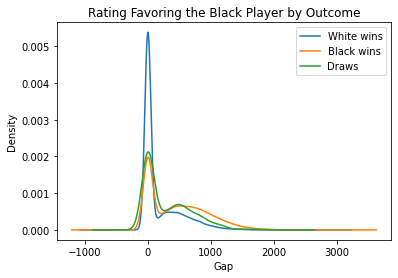

In [151]:
white_winner_black_gap.plot.density()
black_winner_black_gap.plot.density()
draw_black_gap.plot.density()
plt.title('Rating Favoring the Black Player by Outcome')
plt.xlabel('Gap')
plt.legend(['White wins', 'Black wins', 'Draws'])
plt.show()

In [152]:
pd.DataFrame({
  'white': white_winner_neutral_gap.value_counts(normalize=True),
  'black': black_winner_neutral_gap.value_counts(normalize=True),
  'draw': draw_neutral_gap.value_counts(normalize=True)
}).rename_axis(index='rating_gap_neutral', columns='outcome')

outcome,white,black,draw
rating_gap_neutral,,,
False,0.991248,0.989892,0.986996
True,0.008752,0.010108,0.013004


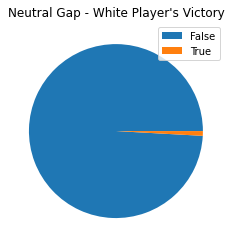

In [153]:
plt.pie(white_winner_neutral_gap.value_counts())
plt.title("Neutral Gap - White Player's Victory")
plt.legend(white_winner_neutral_gap.value_counts().keys())
plt.show()

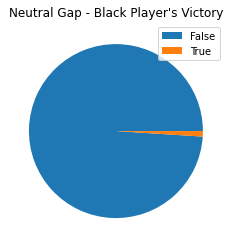

In [154]:
plt.pie(black_winner_neutral_gap.value_counts())
plt.title("Neutral Gap - Black Player's Victory")
plt.legend(black_winner_neutral_gap.value_counts().keys())
plt.show()

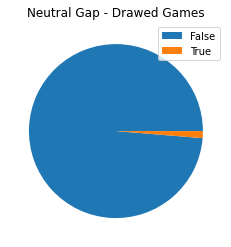

In [155]:
plt.pie(draw_neutral_gap.value_counts())
plt.title("Neutral Gap - Drawed Games")
plt.legend(draw_neutral_gap.value_counts().keys())
plt.show()

Do these groups make any difference? Do they help us distinguish the outcomes one from another?

In [156]:
test_series_equality(
  white_winner_white_gap,
  black_winner_white_gap,
  draw_white_gap
)

False

In [157]:
test_series_equality(
  white_winner_black_gap,
  black_winner_black_gap,
  draw_black_gap
)

False

In [158]:
test_populations_dependency(
  df_chess['rating_gap_neutral'],
  df_chess['winner']
)

False

It seems there's no distinction between the groupings for neutral gaps, but there is for gaps favoring some player.

Does the groupings stand out from the rest?

In [159]:
# 'white' vs. Rest
test_series_equality(
  white_winner_white_gap,
  df_chess['rating_gap_white'][~filt_games_white_won]
)

False

In [160]:
# 'black' vs. Rest
test_series_equality(
  black_winner_white_gap,
  df_chess['rating_gap_white'][~filt_games_black_won]
)

False

In [161]:
# 'draw' vs. Rest
test_series_equality(
  draw_white_gap,
  df_chess['rating_gap_white'][~filt_games_tied]
)

False

In [162]:
# 'white' vs. Rest
test_series_equality(
  white_winner_black_gap,
  df_chess['rating_gap_black'][~filt_games_white_won]
)

False

In [163]:
# 'black' vs. Rest
test_series_equality(
  black_winner_black_gap,
  df_chess['rating_gap_black'][~filt_games_black_won]
)

False

In [164]:
# 'draw' vs. Rest
test_series_equality(
  draw_black_gap,
  df_chess['rating_gap_black'][~filt_games_tied]
)

True

It seems we'll be able to extract features from the columns `rating_gap_white` and `rating_gap_black`.

##### Does the number of checks made by a player have any influence in the outcome?

Now for something that's currently not in the dataset (not explicitly, that is): the number of checks made by a player throughout the game.

We'll have to generate this information by parsing the moves' codes in the game. As I mentioned earlier in code, checks are represented by a "+" sufixing the move description. The _white_ player's moves are in even positions in the list, while the _black_ player's are in odd positions.

In [165]:
df_chess['white_moves'] = df_chess['moves'].apply(lambda moves: moves[::2])
df_chess['black_moves'] = df_chess['moves'].apply(lambda moves: moves[1::2])

In [166]:
df_chess[['white_checks', 'black_checks']] =\
  df_chess[['white_moves', 'black_moves']]\
    .applymap(lambda moves: [bool(re.match(r'.+\+$', m)) for m in moves])\
    .applymap(sum)

In [167]:
df_chess[['white_checks', 'black_checks']].describe()

,white_checks,black_checks
count,17793.000000,17793.000000
mean,2.486933,2.267240
std,3.292330,3.146976
min,0.000000,0.000000
25%,0.000000,0.000000
50%,1.000000,1.000000
75%,3.000000,3.000000
max,34.000000,41.000000


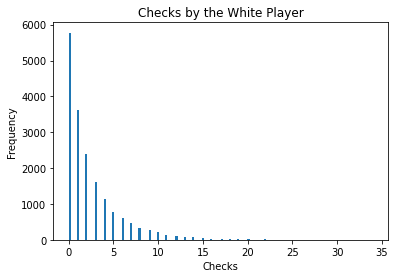

In [168]:
plt.hist(df_chess['white_checks'], bins='fd')
plt.title('Checks by the White Player')
plt.xlabel('Checks')
plt.ylabel('Frequency')
plt.show()

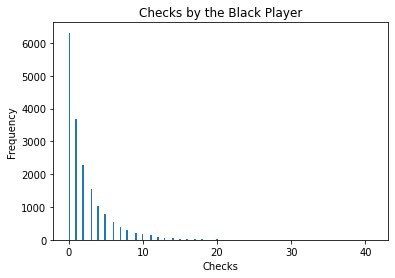

In [169]:
plt.hist(df_chess['black_checks'], bins='fd')
plt.title('Checks by the Black Player')
plt.xlabel('Checks')
plt.ylabel('Frequency')
plt.show()

And does the checks count help us distinguish the outcomes of a game?

In [170]:
white_winner_white_checks = df_chess['white_checks'][filt_games_white_won]
black_winner_white_checks = df_chess['white_checks'][filt_games_black_won]
draw_white_checks = df_chess['white_checks'][filt_games_tied]

white_winner_black_checks = df_chess['black_checks'][filt_games_white_won]
black_winner_black_checks = df_chess['black_checks'][filt_games_black_won]
draw_black_checks = df_chess['black_checks'][filt_games_tied]

In [171]:
pd.DataFrame({
  'white': white_winner_white_checks.describe(),
  'black': black_winner_white_checks.describe(),
  'draw': draw_white_checks.describe()
}).rename_axis(index='stat', columns='outcome')

outcome,white,black,draw
stat,,,
count,8912.000000,8112.000000,769.000000
mean,3.084605,1.676652,4.107932
std,3.540810,2.552442,4.809122
min,0.000000,0.000000,0.000000
25%,1.000000,0.000000,1.000000
50%,2.000000,1.000000,2.000000
75%,4.000000,2.000000,6.000000
max,34.000000,31.000000,33.000000


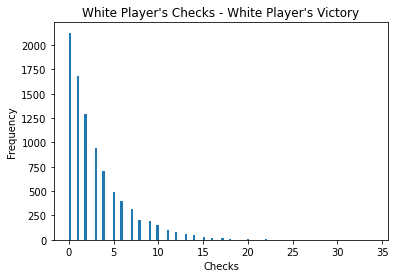

In [172]:
plt.hist(white_winner_white_checks, bins='fd')
plt.title("White Player's Checks - White Player's Victory")
plt.xlabel('Checks')
plt.ylabel('Frequency')
plt.show()

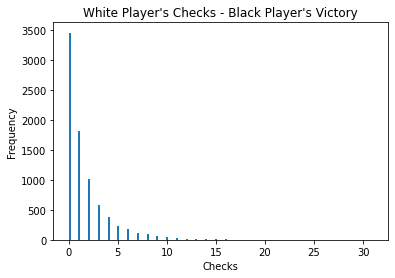

In [173]:
plt.hist(black_winner_white_checks, bins='fd')
plt.title("White Player's Checks - Black Player's Victory")
plt.xlabel('Checks')
plt.ylabel('Frequency')
plt.show()

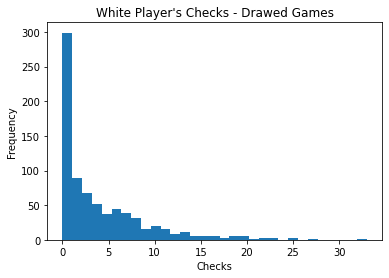

In [174]:
plt.hist(draw_white_checks, bins='fd')
plt.title("White Player's Checks - Drawed Games")
plt.xlabel('Checks')
plt.ylabel('Frequency')
plt.show()

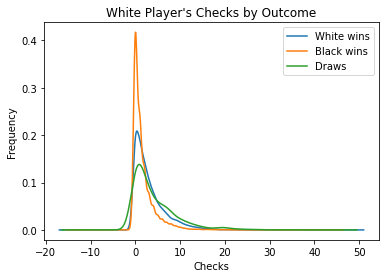

In [175]:
white_winner_white_checks.plot.density()
black_winner_white_checks.plot.density()
draw_white_checks.plot.density()
plt.title("White Player's Checks by Outcome")
plt.xlabel('Checks')
plt.ylabel('Frequency')
plt.legend(['White wins', 'Black wins', 'Draws'])
plt.show()

In [176]:
pd.DataFrame({
  'white': white_winner_black_checks.describe(),
  'black': black_winner_black_checks.describe(),
  'draw': draw_black_checks.describe()
}).rename_axis(index='stat', columns='outcome')

outcome,white,black,draw
stat,,,
count,8912.000000,8112.000000,769.000000
mean,1.436041,3.035256,3.798440
std,2.370127,3.491044,4.352286
min,0.000000,0.000000,0.000000
25%,0.000000,1.000000,1.000000
50%,1.000000,2.000000,2.000000
75%,2.000000,4.000000,6.000000
max,35.000000,41.000000,26.000000


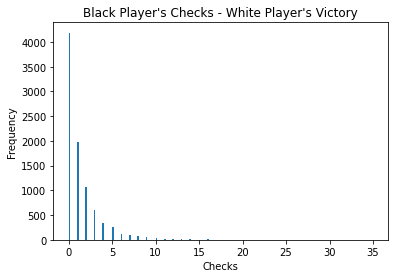

In [177]:
plt.hist(white_winner_black_checks, bins='fd')
plt.title("Black Player's Checks - White Player's Victory")
plt.xlabel('Checks')
plt.ylabel('Frequency')
plt.show()

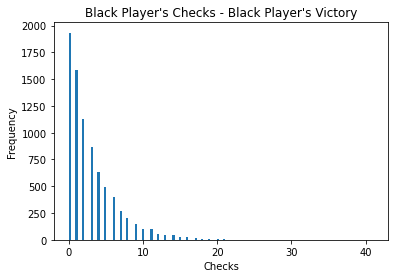

In [178]:
plt.hist(black_winner_black_checks, bins='fd')
plt.title("Black Player's Checks - Black Player's Victory")
plt.xlabel('Checks')
plt.ylabel('Frequency')
plt.show()

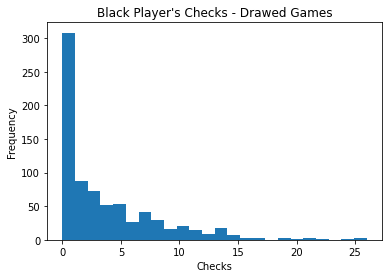

In [179]:
plt.hist(draw_black_checks, bins='fd')
plt.title("Black Player's Checks - Drawed Games")
plt.xlabel('Checks')
plt.ylabel('Frequency')
plt.show()

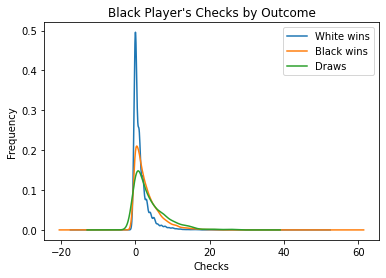

In [180]:
white_winner_black_checks.plot.density()
black_winner_black_checks.plot.density()
draw_black_checks.plot.density()
plt.title("Black Player's Checks by Outcome")
plt.xlabel('Checks')
plt.ylabel('Frequency')
plt.legend(['White wins', 'Black wins', 'Draws'])
plt.show()

Does these groupings help us distinguish the outcomes one from another?

In [181]:
test_series_equality(
  white_winner_white_checks,
  black_winner_white_checks,
  draw_white_checks
)

False

In [182]:
test_series_equality(
  white_winner_black_checks,
  black_winner_black_checks,
  draw_black_checks
)

False

They just might.

In [183]:
# 'white' vs. Rest
test_series_equality(
  white_winner_white_checks,
  df_chess['white_checks'][~filt_games_white_won]
)

False

In [184]:
# 'black' vs. Rest
test_series_equality(
  black_winner_white_checks,
  df_chess['white_checks'][~filt_games_black_won]
)

False

In [185]:
# 'draw' vs. Rest
test_series_equality(
  draw_white_checks,
  df_chess['white_checks'][~filt_games_tied]
)

False

In [186]:
# 'white' vs. Rest
test_series_equality(
  white_winner_black_checks,
  df_chess['black_checks'][~filt_games_white_won]
)

False

In [187]:
# 'black' vs. Rest
test_series_equality(
  black_winner_black_checks,
  df_chess['black_checks'][~filt_games_black_won]
)

False

In [188]:
# 'draw' vs. Rest
test_series_equality(
  draw_black_checks,
  df_chess['black_checks'][~filt_games_tied]
)

False

We'll extract features from the columns `white_checks` and `black_checks`.

##### Does the capture of the opponent's pieces have any influence over the outcome?

Does capturing the opponent's pieces or losing your own have any impact on the outcome of the game? Does your chance of winning increases as you capture the opponent's pieces? Does it decreases as you lose your own pieces?

We can determine that number by parsing the moves made by the player. Each move containing a "x" is a move where an opponent's piece was captured by that player (we already know that all moves are in accordance to the Algebraic Notation).

In [189]:
df_chess[['white_captures', 'black_captures']] =\
  df_chess[['white_moves', 'black_moves']]\
    .applymap(lambda moves: sum('x' in m for m in moves))

In [190]:
df_chess[['white_captures', 'black_captures']].describe()

,white_captures,black_captures
count,17793.000000,17793.000000
mean,7.249930,7.202945
std,3.783718,3.810632
min,0.000000,0.000000
25%,4.000000,4.000000
50%,7.000000,7.000000
75%,10.000000,10.000000
max,15.000000,15.000000


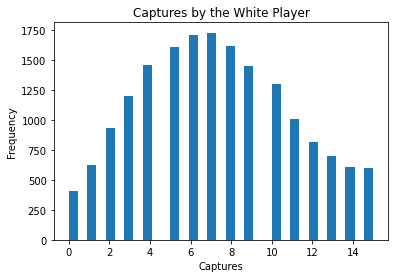

In [191]:
plt.hist(df_chess['white_captures'], bins='fd')
plt.title("Captures by the White Player")
plt.xlabel('Captures')
plt.ylabel('Frequency')
plt.show()

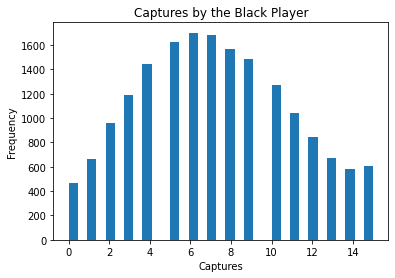

In [192]:
plt.hist(df_chess['black_captures'], bins='fd')
plt.title("Captures by the Black Player")
plt.xlabel('Captures')
plt.ylabel('Frequency')
plt.show()

And then we can analyze it to determine whether that info can help us distinguish an outcome from another.

In [193]:
white_winner_white_captures = df_chess['white_captures'][filt_games_white_won]
black_winner_white_captures = df_chess['white_captures'][filt_games_black_won]
draw_white_captures = df_chess['white_captures'][filt_games_tied]

white_winner_black_captures = df_chess['black_captures'][filt_games_white_won]
black_winner_black_captures = df_chess['black_captures'][filt_games_black_won]
draw_black_captures = df_chess['black_captures'][filt_games_tied]

In [194]:
pd.DataFrame({
  'white': white_winner_white_captures.describe(),
  'black': black_winner_white_captures.describe(),
  'draw': draw_white_captures.describe()
}).rename_axis(index='stat', columns='outcome')

outcome,white,black,draw
stat,,,
count,8912.000000,8112.000000,769.000000
mean,7.727671,6.525764,9.352406
std,3.887402,3.395999,4.680898
min,0.000000,0.000000,0.000000
25%,5.000000,4.000000,6.000000
50%,8.000000,6.000000,10.000000
75%,11.000000,9.000000,14.000000
max,15.000000,15.000000,15.000000


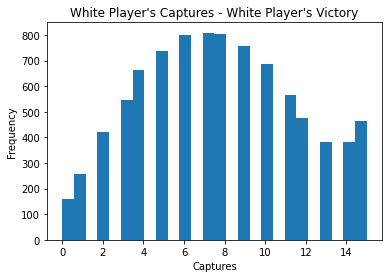

In [195]:
plt.hist(white_winner_white_captures, bins='fd')
plt.title("White Player's Captures - White Player's Victory")
plt.xlabel('Captures')
plt.ylabel('Frequency')
plt.show()

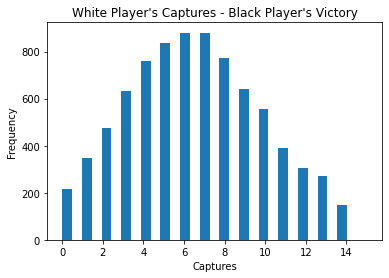

In [196]:
plt.hist(black_winner_white_captures, bins='fd')
plt.title("White Player's Captures - Black Player's Victory")
plt.xlabel('Captures')
plt.ylabel('Frequency')
plt.show()

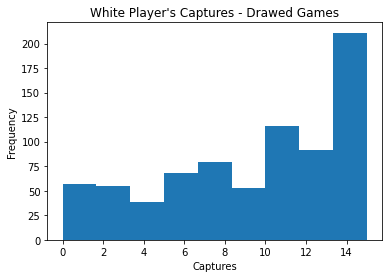

In [197]:
plt.hist(draw_white_captures, bins='fd')
plt.title("White Player's Captures - Drawed Games")
plt.xlabel('Captures')
plt.ylabel('Frequency')
plt.show()

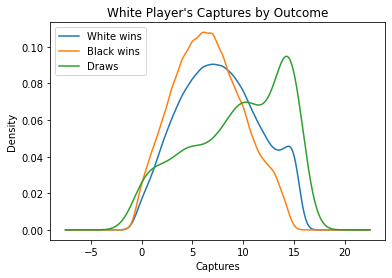

In [198]:
white_winner_white_captures.plot.density()
black_winner_white_captures.plot.density()
draw_white_captures.plot.density()
plt.title("White Player's Captures by Outcome")
plt.xlabel('Captures')
plt.legend(['White wins', 'Black wins', 'Draws'])
plt.show()

In [199]:
pd.DataFrame({
  'white': white_winner_black_captures.describe(),
  'black': black_winner_black_captures.describe(),
  'draw': draw_black_captures.describe()
}).rename_axis(index='stat', columns='outcome')

outcome,white,black,draw
stat,,,
count,8912.000000,8112.000000,769.000000
mean,6.190642,8.106755,9.400520
std,3.423747,3.810541,4.656794
min,0.000000,0.000000,0.000000
25%,4.000000,5.000000,6.000000
50%,6.000000,8.000000,10.000000
75%,9.000000,11.000000,14.000000
max,15.000000,15.000000,15.000000


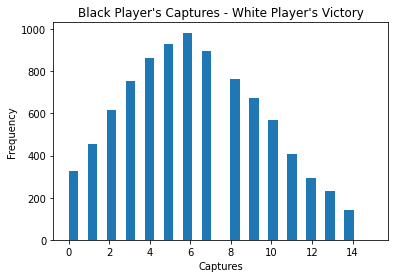

In [200]:
plt.hist(white_winner_black_captures, bins='fd')
plt.title("Black Player's Captures - White Player's Victory")
plt.xlabel('Captures')
plt.ylabel('Frequency')
plt.show()

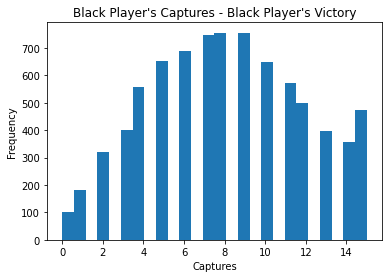

In [201]:
plt.hist(black_winner_black_captures, bins='fd')
plt.title("Black Player's Captures - Black Player's Victory")
plt.xlabel('Captures')
plt.ylabel('Frequency')
plt.show()

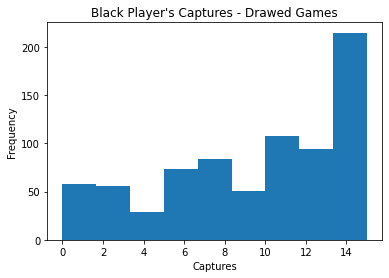

In [202]:
plt.hist(draw_black_captures, bins='fd')
plt.title("Black Player's Captures - Drawed Games")
plt.xlabel('Captures')
plt.ylabel('Frequency')
plt.show()

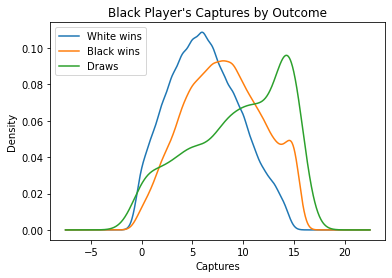

In [203]:
white_winner_black_captures.plot.density()
black_winner_black_captures.plot.density()
draw_black_captures.plot.density()
plt.title("Black Player's Captures by Outcome")
plt.xlabel('Captures')
plt.legend(['White wins', 'Black wins', 'Draws'])
plt.show()

It's interesting to notice that, for both the _white_ and _black_ player, their captures do not exceed `15` pieces. That is, all the opponent's pieces except for the King, which validates those numbers.

We can test if all those groupings are equal to each other or not.

In [204]:
test_series_equality(
  white_winner_white_captures,
  black_winner_white_captures,
  draw_white_captures
)

False

In [205]:
test_series_equality(
  white_winner_black_captures,
  black_winner_black_captures,
  draw_black_captures
)

False

Since they aren't, at least one of them stands out from the rest of the sample.

In [206]:
# 'white' vs. Rest
test_series_equality(
  white_winner_white_captures,
  df_chess['white_captures'][~filt_games_white_won]
)

False

In [207]:
# 'black' vs. Rest
test_series_equality(
  black_winner_white_captures,
  df_chess['white_captures'][~filt_games_black_won]
)

False

In [208]:
# 'draw' vs. Rest
test_series_equality(
  draw_white_captures,
  df_chess['white_captures'][~filt_games_tied]
)

False

In [209]:
# 'white' vs. Rest
test_series_equality(
  white_winner_black_captures,
  df_chess['black_captures'][~filt_games_white_won]
)

False

In [210]:
# 'black' vs. Rest
test_series_equality(
  black_winner_black_captures,
  df_chess['black_captures'][~filt_games_black_won]
)

False

In [211]:
# 'draw' vs. Rest
test_series_equality(
  draw_black_captures,
  df_chess['black_captures'][~filt_games_tied]
)

False

It seems all of them are distinguishable and might help us determine the outcome of a game. We can extract some features from `white_captures` and `black_captures`.

##### Does the difference between the players' captures have any influence over the outcome?

Do we have a case similar to that of the rating gap when it comes to the difference between the players' captures?

In [212]:
df_chess['captures_diff'] = (df_chess['white_captures']\
                             - df_chess['black_captures'])

In [213]:
df_chess[['captures_diff']].describe()

,captures_diff
count,17793.000000
mean,0.046985
std,2.469903
min,-12.000000
25%,-1.000000
50%,0.000000
75%,1.000000
max,12.000000


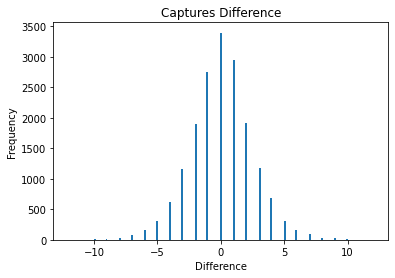

In [214]:
plt.hist(df_chess['captures_diff'], bins='fd')
plt.title('Captures Difference')
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.show()

Once again, we have a seemingly balanced distribution. We know that, as it was with the case for the rating gap, the difference may favor a player over another. How does it look like for this column?

In [215]:
white_winner_captures_diff = df_chess['captures_diff'][filt_games_white_won]
black_winner_captures_diff = df_chess['captures_diff'][filt_games_black_won]
draw_captures_diff = df_chess['captures_diff'][filt_games_tied]

In [216]:
pd.DataFrame({
  'white': white_winner_captures_diff.describe(),
  'black': black_winner_captures_diff.describe(),
  'draw': draw_captures_diff.describe()
}).rename_axis(index='stat', columns='outcome')

outcome,white,black,draw
stat,,,
count,8912.000000,8112.000000,769.000000
mean,1.537029,-1.580991,-0.048114
std,1.978841,1.946099,1.458283
min,-7.000000,-12.000000,-10.000000
25%,0.000000,-3.000000,-1.000000
50%,1.000000,-1.000000,0.000000
75%,3.000000,0.000000,1.000000
max,12.000000,7.000000,6.000000


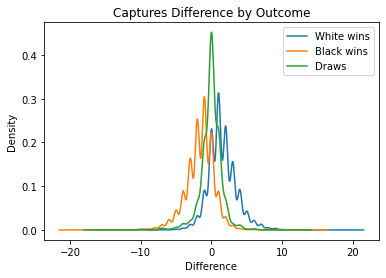

In [217]:
white_winner_captures_diff.plot.density()
black_winner_captures_diff.plot.density()
draw_captures_diff.plot.density()
plt.title('Captures Difference by Outcome')
plt.xlabel('Difference')
plt.legend(['White wins', 'Black wins', 'Draws'])
plt.show()

The distribution seems balanced for drawed games, and the others lean in favor of their respective winning player. The distinction isn't much noticeable, however.

Let's try to highlight the difference as did for the rating gap.

In [218]:
diff_of_squares = (df_chess['white_captures'] ** 2\
                   - df_chess['black_captures'] ** 2)

df_chess['captures_diff'] = np.sign(diff_of_squares)\
                            * diff_of_squares.abs() ** (1 / 2)

In [219]:
df_chess[['captures_diff']].describe()

,captures_diff
count,17793.000000
mean,0.073245
std,5.443693
min,-14.696938
25%,-4.358899
50%,0.000000
75%,4.472136
max,14.696938


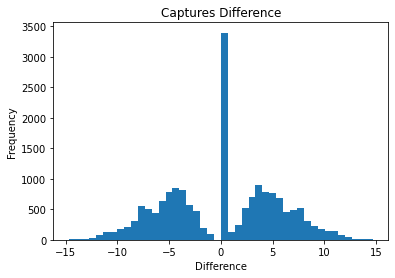

In [220]:
plt.hist(df_chess['captures_diff'], bins='fd')
plt.title('Captures Difference')
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.show()

Now we got more distinct groups. Let's continue.

In [221]:
white_winner_captures_diff = df_chess['captures_diff'][filt_games_white_won]
black_winner_captures_diff = df_chess['captures_diff'][filt_games_black_won]
draw_captures_diff = df_chess['captures_diff'][filt_games_tied]

In [222]:
pd.DataFrame({
  'white': white_winner_captures_diff.describe(),
  'black': black_winner_captures_diff.describe(),
  'draw': draw_captures_diff.describe()
}).rename_axis(index='stat', columns='outcome')

outcome,white,black,draw
stat,,,
count,8912.000000,8112.000000,769.000000
mean,3.496065,-3.681247,0.011178
std,4.177835,4.151320,4.140580
min,-10.246951,-14.696938,-14.142136
25%,0.000000,-6.633250,-2.645751
50%,3.872983,-4.123106,0.000000
75%,6.324555,0.000000,3.605551
max,14.696938,10.954451,12.000000


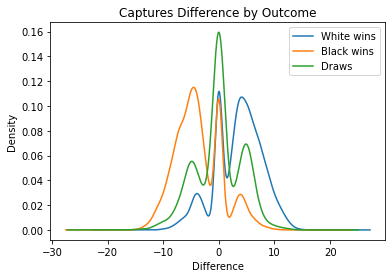

In [223]:
white_winner_captures_diff.plot.density()
black_winner_captures_diff.plot.density()
draw_captures_diff.plot.density()
plt.title('Captures Difference by Outcome')
plt.xlabel('Difference')
plt.legend(['White wins', 'Black wins', 'Draws'])
plt.show()

Again, let's split those values in three columns: a difference favoring the _white_ player, a difference favoring the _black_ player, and a perfectly neutral difference.

In [224]:
df_chess['captures_diff_white'] = df_chess['captures_diff']\
  .apply(lambda x: x if x > .0 else .0)

df_chess['captures_diff_black'] = df_chess['captures_diff']\
  .apply(lambda x: -x if x < .0 else .0)

df_chess['captures_diff_neutral'] = (df_chess['captures_diff'] == .0)

In [225]:
df_chess[['captures_diff_white', 'captures_diff_black']].describe()

,captures_diff_white,captures_diff_black
count,17793.000000,17793.000000
mean,2.271527,2.198281
std,3.145920,3.122421
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,4.472136,4.358899
max,14.696938,14.696938


In [226]:
pd.DataFrame(df_chess['captures_diff_neutral'].value_counts())

,captures_diff_neutral
False,14395
True,3398


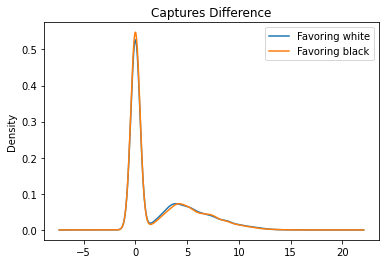

In [227]:
df_chess['captures_diff_white'].plot.density()
df_chess['captures_diff_black'].plot.density()
plt.title("Captures Difference")
plt.legend(['Favoring white', 'Favoring black'])
plt.show()

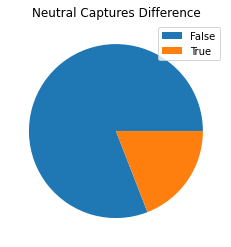

In [228]:
plt.pie(df_chess['captures_diff_neutral'].value_counts())
plt.legend(df_chess['captures_diff_neutral'].value_counts().keys())
plt.title('Neutral Captures Difference')
plt.show()

And now we cross them with the outcome.

In [229]:
white_winner_white_captures_diff = df_chess['captures_diff_white'][filt_games_white_won]
black_winner_white_captures_diff = df_chess['captures_diff_white'][filt_games_black_won]
draw_white_captures_diff = df_chess['captures_diff_white'][filt_games_tied]

white_winner_black_captures_diff = df_chess['captures_diff_black'][filt_games_white_won]
black_winner_black_captures_diff = df_chess['captures_diff_black'][filt_games_black_won]
draw_black_captures_diff = df_chess['captures_diff_black'][filt_games_tied]

white_winner_neutral_captures_diff = df_chess['captures_diff_neutral'][filt_games_white_won]
black_winner_neutral_captures_diff = df_chess['captures_diff_neutral'][filt_games_black_won]
draw_neutral_captures_diff = df_chess['captures_diff_neutral'][filt_games_tied]

In [230]:
pd.DataFrame({
  'white': white_winner_white_captures_diff.describe(),
  'black': black_winner_white_captures_diff.describe(),
  'draw': draw_white_captures_diff.describe()
}).rename_axis(index='stat', columns='outcome')

outcome,white,black,draw
stat,,,
count,8912.000000,8112.000000,769.000000
mean,3.983857,0.466013,1.473141
std,3.370271,1.453989,2.461728
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,3.872983,0.000000,0.000000
75%,6.324555,0.000000,3.605551
max,14.696938,10.954451,12.000000


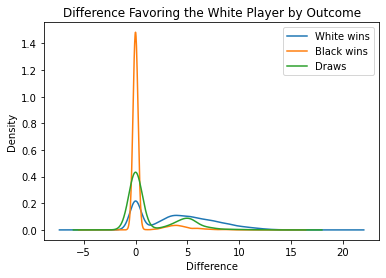

In [231]:
white_winner_white_captures_diff.plot.density()
black_winner_white_captures_diff.plot.density()
draw_white_captures_diff.plot.density()
plt.title("Difference Favoring the White Player by Outcome")
plt.xlabel('Difference')
plt.legend(['White wins', 'Black wins', 'Draws'])
plt.show()

In [232]:
pd.DataFrame({
  'white': white_winner_black_captures_diff.describe(),
  'black': black_winner_black_captures_diff.describe(),
  'draw': draw_black_captures_diff.describe()
}).rename_axis(index='stat', columns='outcome')

outcome,white,black,draw
stat,,,
count,8912.000000,8112.000000,769.000000
mean,0.487792,4.147260,1.461963
std,1.486122,3.354631,2.602180
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,4.123106,0.000000
75%,0.000000,6.633250,2.645751
max,10.246951,14.696938,14.142136


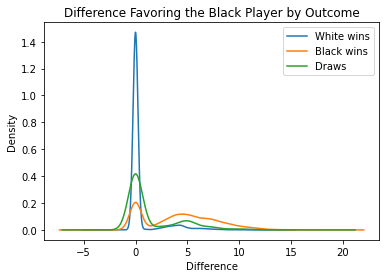

In [233]:
white_winner_black_captures_diff.plot.density()
black_winner_black_captures_diff.plot.density()
draw_black_captures_diff.plot.density()
plt.title("Difference Favoring the Black Player by Outcome")
plt.xlabel('Difference')
plt.legend(['White wins', 'Black wins', 'Draws'])
plt.show()

In [234]:
pd.DataFrame({
  'white': white_winner_neutral_captures_diff.value_counts(normalize=True),
  'black': black_winner_neutral_captures_diff.value_counts(normalize=True),
  'draw': draw_neutral_captures_diff.value_counts(normalize=True)
}).rename_axis(index='captures_diff_neutral', columns='outcome')

outcome,white,black,draw
captures_diff_neutral,,,
False,0.816539,0.822855,0.576073
True,0.183461,0.177145,0.423927


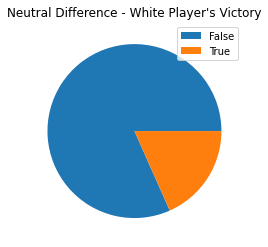

In [235]:
plt.pie(white_winner_neutral_captures_diff.value_counts())
plt.title("Neutral Difference - White Player's Victory")
plt.legend(white_winner_neutral_captures_diff.value_counts().keys())
plt.show()

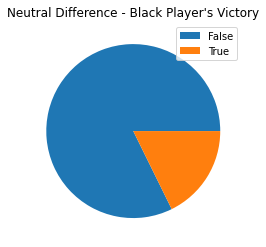

In [236]:
plt.pie(black_winner_neutral_captures_diff.value_counts())
plt.title("Neutral Difference - Black Player's Victory")
plt.legend(black_winner_neutral_captures_diff.value_counts().keys())
plt.show()

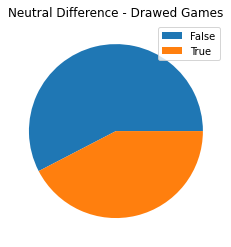

In [237]:
plt.pie(draw_neutral_captures_diff.value_counts())
plt.title("Neutral Difference - Drawed Games")
plt.legend(draw_neutral_captures_diff.value_counts().keys())
plt.show()

Do these groups make any difference? Do they help us distinguish the outcomes one from another?

In [238]:
test_series_equality(
  white_winner_white_captures_diff,
  black_winner_white_captures_diff,
  draw_white_captures_diff,
)

False

In [239]:
test_series_equality(
  white_winner_white_captures_diff,
  black_winner_white_captures_diff,
  draw_white_captures_diff,
)

False

In [240]:
test_populations_dependency(
  df_chess['captures_diff_neutral'],
  df_chess['winner']
)

True

We can use `captures_diff_white`, `captures_diff_black` and `captures_diff_neutral` to extract features.

## The Model

Now comes the part where we build our classification model. The modified dataset has ~18 thousand games. I consider that to be a rather small dataset for the small number of features we're taking into consideration.

My strategy will be:

1. Use hold-out to split the dataset into training and test sets (80%/20%);
1. Choose the best algorithm:
   1. Evaluate the performance of each algorithm through k-fold cross-validation (5 folds);
   1. Use grid search to optmize the values of the hyper-parameters;
   1. Choose the algorithm with the best average score;
1. Build and train a model with the chosen algorithm using the training set;
1. Evaluate the model's score with the testing set.

For this project, I'm aiming for a high precision, rather than a high recall. That's because I want to be as sure as I can in my predictions, instead of detecting as many true positives as I can. I'm going to use weighted precision to compare the algorithms and to evaluate the model, since the classes (white wins, black wins, draw) are unbalanced in the dataset.

It's also important to note that all splittings of our data are going to be stratified because this is a classification problem.

In [241]:
from sklearn.model_selection import train_test_split

DEFAULT_RANDOM_STATE = 2020

# Split the dataset into a 80% size training set and
# a 20% size testing set.
(df_chess_train, df_chess_test) = (
  pd.DataFrame(obs_set, columns=df_chess.columns)
  for obs_set in train_test_split(
      df_chess,
      stratify=df_chess['winner'],
      train_size=.8,
      shuffle=True,
      random_state=DEFAULT_RANDOM_STATE
    )
)

In [242]:
len(df_chess_train)

14234

In [243]:
df_chess_train['winner'].value_counts()

white    7129
black    6490
draw      615
Name: winner, dtype: int64

In [244]:
len(df_chess_test)

3559

In [245]:
df_chess_test['winner'].value_counts()

white    1783
black    1622
draw      154
Name: winner, dtype: int64

### Building the Features

We'll consider the following variables as features of our model:

- Number of turns in the game (`turns`);
- Each player's rating (`white_rating` and `black_rating`);
- Rating gap (`player_rating_gap`);
- Each player's number of checks (`white_checks` and `black_checks`);
- Difference between the number of checks (`check_difference`);
- Each player's captured opponent's pieces count (`white_captures` and `black_captures`);
- Difference between the number of captured opponent's pieces (`captures_difference`);

I choosed to design a function to encapsulate the process of fitting the datasets. This fitting function returns a transformation function with the encoders stored inside the function's closure. With that, I can keep the encoders' fittings and reuse them.

In [246]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

def chess_fit(dataset):
  encoders = [
    (
      MinMaxScaler((0, 1)),
      [
        'turns',
        'white_rating', 'black_rating',
        'white_checks', 'black_checks',
        'white_captures', 'black_captures',
        'rating_gap_white', 'rating_gap_black',
        'captures_diff_white', 'captures_diff_black'
      ]
    ),
    (
      OneHotEncoder(
        categories=[[True]],
        sparse=False,
        handle_unknown='ignore'
      ),
      ['captures_diff_neutral']
    )
  ]

  for (enc, cols) in encoders:
    enc.fit(dataset[cols])

  def chess_transform(dataset):
    tfmd_x = np.hstack([
      enc.transform(dataset[cols])
      for (enc, cols) in encoders
    ])
    return (tfmd_x, dataset['winner'])
    
  return chess_transform

In [247]:
feat_builder = chess_fit(df_chess_train)

In [248]:
(df_train_features, df_train_classes) = feat_builder(df_chess_train)

### Choosing the Best Algorithm

For this project, I'll evaluate the following classification algorithms, choosing the one which performs the best:

- Multi-Class Logistic Regression;
- Decision Tree;
- Random Forest.

In [249]:
import enum
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier  

class ClassifierAlg(enum.IntEnum):
  LOGISTIC_REGRESSION = enum.auto()
  DECISION_TREE = enum.auto()
  RANDOM_FOREST = enum.auto()

def build_model(alg: ClassifierAlg):
  estimator = None
  param_grid = None

  if alg is ClassifierAlg.LOGISTIC_REGRESSION:
    estimator = LogisticRegression(
      solver='saga',
      random_state=DEFAULT_RANDOM_STATE,
      n_jobs=-1
    )

    param_grid = {
      'penalty': ['l2', 'elasticnet'],
      'tol': [1e-4, 1e-3, .01, .1],
      'C': [1, .5, .1, .05, .01],
      'multi_class': ['multinomial', 'ovr']
    }

  elif alg is ClassifierAlg.DECISION_TREE:
    estimator = DecisionTreeClassifier(random_state=DEFAULT_RANDOM_STATE)

    param_grid = {
      'criterion': ['entropy', 'gini'],
      'max_depth': list(range(3, 11))
    }

  elif alg is ClassifierAlg.RANDOM_FOREST:
    estimator = RandomForestClassifier(
      random_state=DEFAULT_RANDOM_STATE,
      n_jobs=-1
    )

    param_grid = {
      'n_estimators': [10, 20, 50, 100],
      'criterion': ['entropy', 'gini'],
      'max_depth': list(range(3, 11))
    }
    
  return GridSearchCV(
    estimator,
    param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=False),
    scoring='precision_weighted',
    n_jobs=-1
  )

We'll run each algorithm through stratified k-folds cross-validation and select the one with the best weighted precision.

In [250]:
from sklearn.model_selection import cross_validate

EVAL_SCORE = 'precision_weighted'

def evaluate_algorithms(train_x, train_y):
  def cv_evaluate_algorithm(alg: ClassifierAlg):
    eval_results = cross_validate(
      build_model(alg),
      train_x,
      train_y,
      cv=StratifiedKFold(n_splits=5, shuffle=False),
      scoring=EVAL_SCORE,
      return_train_score=True,
      n_jobs=-1
    )
    return np.mean(
      [eval_results['train_score'],
       eval_results['test_score']],
      axis=1
    )

  return pd.DataFrame(
    data=[cv_evaluate_algorithm(alg) for alg in ClassifierAlg],
    columns=pd.Index(
      ['train', 'test'],
      name=EVAL_SCORE
    ),
    index=pd.Index(
      [alg.name for alg in ClassifierAlg],
      name='algorithm'
    )
  )

In [251]:
algorithms_evaluation = evaluate_algorithms(df_train_features, df_train_classes)

In [252]:
algorithms_evaluation

precision_weighted,train,test
algorithm,,
LOGISTIC_REGRESSION,0.789036,0.783300
DECISION_TREE,0.801887,0.795905
RANDOM_FOREST,0.808284,0.807146


All three algorithms performed close to 80% precision. However, the Random Forest classifier displays the best performance out of the three. So we're going to use a Random Forest classifier to predict the outcome of the games.

### Building the Model

Now we need to train a Random Forest model to use in the test phase.

In [253]:
prediction_model = build_model(ClassifierAlg.RANDOM_FOREST)

prediction_model.fit(df_train_features, df_train_classes)

prediction_model.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=2020, verbose=0,
                       warm_start=False)

## The Test

Finally, we use our trained classification model to predict the outcome of the games of our testing set.

First, we build the features for our testing set with the `feat_builder` that was previously fit with the training set.

In [254]:
(df_test_features, df_test_classes) = feat_builder(df_chess_test)

Then we make the predictions.

In [255]:
predictions = prediction_model.predict(df_test_features)

### Scoring the Results

We score the results to evaluate the performance of our classification model.

In [256]:
from sklearn.metrics import precision_score

precision_score(
  df_test_classes,
  predictions,
  average='weighted',
  zero_division=0
)

0.8006622744378007

Near 80% precision overall. But how well does it fare for each outcome?

In [257]:
possible_outcomes = df_chess['winner'].unique()

pd.DataFrame(
  data=[
    precision_score(
      df_test_classes,
      predictions,
      average='weighted',
      labels=[c],
      zero_division=0
    )
    for c in possible_outcomes
  ],
  columns=[EVAL_SCORE],
  index=pd.Index(
    possible_outcomes,
    name='outcome'
  )
)

,precision_weighted
outcome,
white,0.795008
black,0.787952
draw,1.000000


### Resulting Confusion Matrix

Let's have a look at the confusion matrix for our predictions.

In [258]:
# Pretty much the equivalent to sklearn.metrics.confusion_matrix,
# but easier to read, and with totals.
pd.crosstab(
  df_test_classes,
  predictions,
  rownames=['real'],
  colnames=['prediction'],
  margins=True
)

prediction,black,draw,white,All
real,,,,
black,1308,0,314,1622
draw,66,16,72,154
white,286,0,1497,1783
All,1660,16,1883,3559


And the confusion matrix normalized.

In [259]:
pd.crosstab(
  df_test_classes,
  predictions,
  rownames=['real'],
  colnames=['prediction'],
  margins=True,
  normalize='all'
)

prediction,black,draw,white,All
real,,,,
black,0.367519,0.000000,0.088227,0.455746
draw,0.018545,0.004496,0.020230,0.043271
white,0.080360,0.000000,0.420624,0.500983
All,0.466423,0.004496,0.529081,1.000000
